In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy.stats import gmean

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
dl = DataLib("SignalData")

bondReturnIndex = dl.pull('BondRetIdx/LocalFX')

countries = ['USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU']

In [4]:
def period_return(series):
    startPrice = series[0]
    endPrice = series[-1]
    ret = (endPrice - startPrice)/startPrice
    return ret
hedgedReturnsQuarterly = bondReturnIndex.resample('1Q').apply(period_return)

#pd.options.display.float_format = '{:,.7f}'.format


In [5]:
threeMonthRates = dl.pull("threeMonthRate").resample('1B').ffill()/100
threeMonthDailyEffective = (1+threeMonthRates) ** (1/261) - 1

hedgedReturnsDaily = bondReturnIndex.pct_change()

for country in countries:
    threeMonthDailyEffective[country] = threeMonthDailyEffective['USA']

hedgedReturnsDaily = hedgedReturnsDaily - threeMonthDailyEffective

## Note: All indicators are reported as z-scores. The z-scores are then converted to actual long or short positions (values between -1 and 1) by the getPosition() function.

# Current Account / GDP

### I computed 4 year x 1 year rolling mean for current account/GDP to capture smoothed change over time. CA/GDP captures both potential for future interest rate increases and FX depreciations. If time permits, I may try to incorporate foreign currency reserve data from the IMF to capture the degree to which a given currency acts as a reserve currency.

In [6]:
def getChange(series):
    start = series[0]
    end = series[-1]
    change = (end - start)
    return change

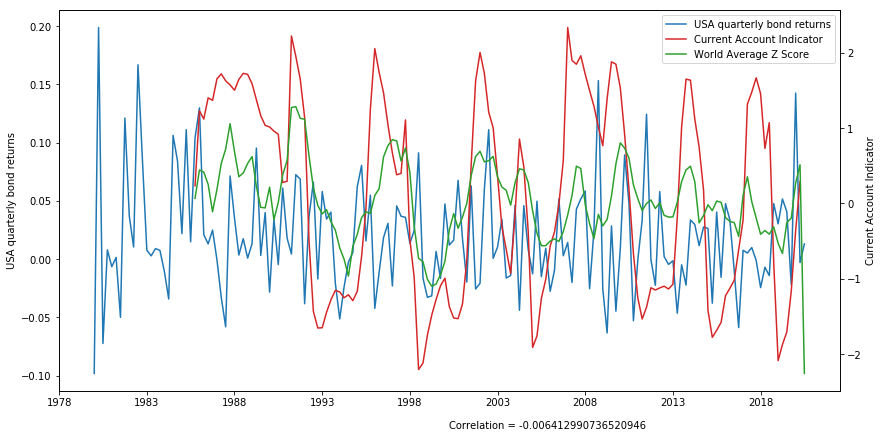

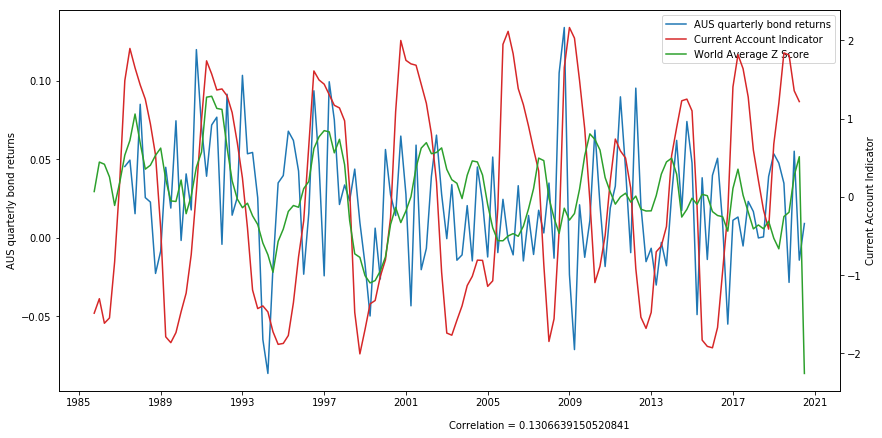

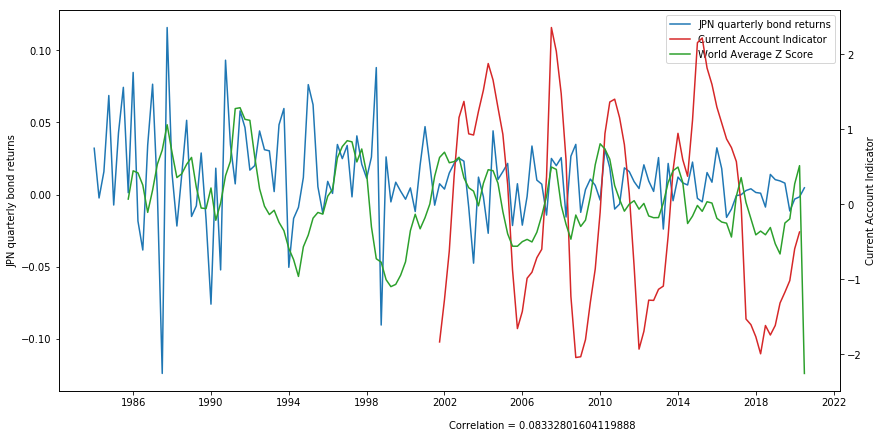

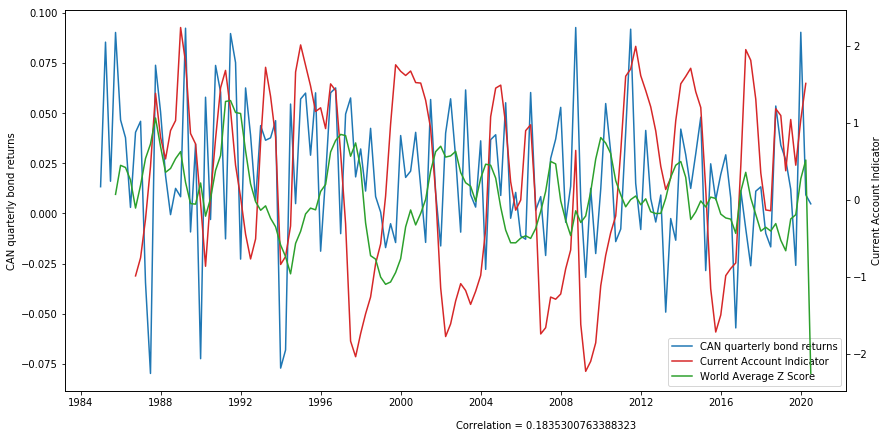

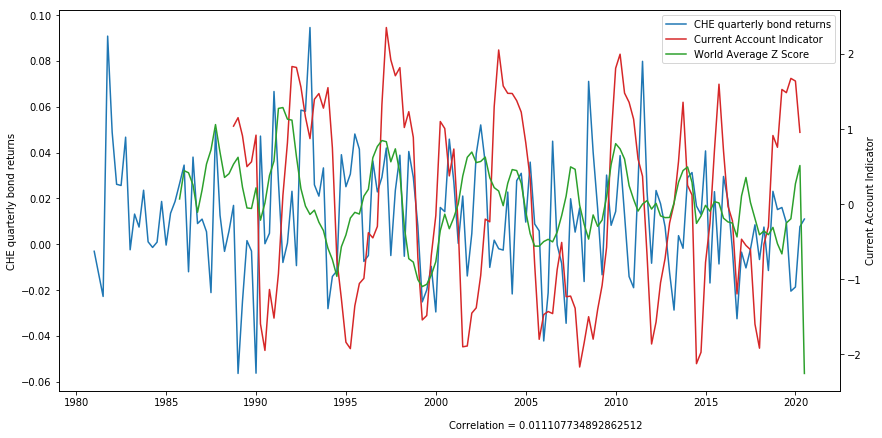

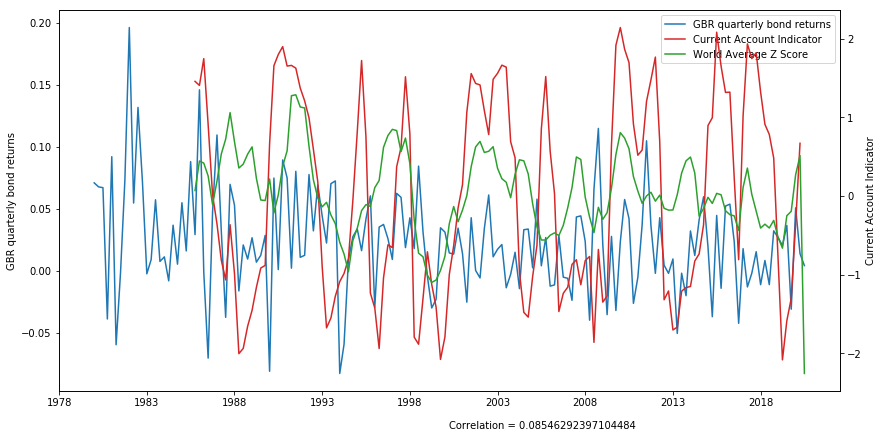

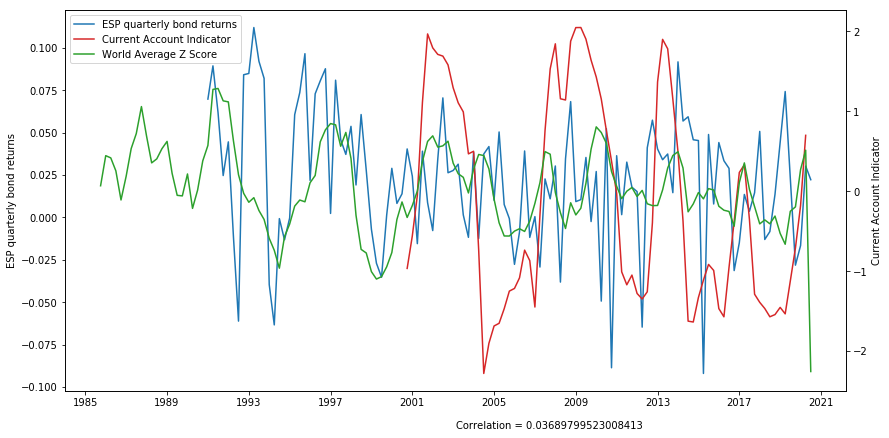

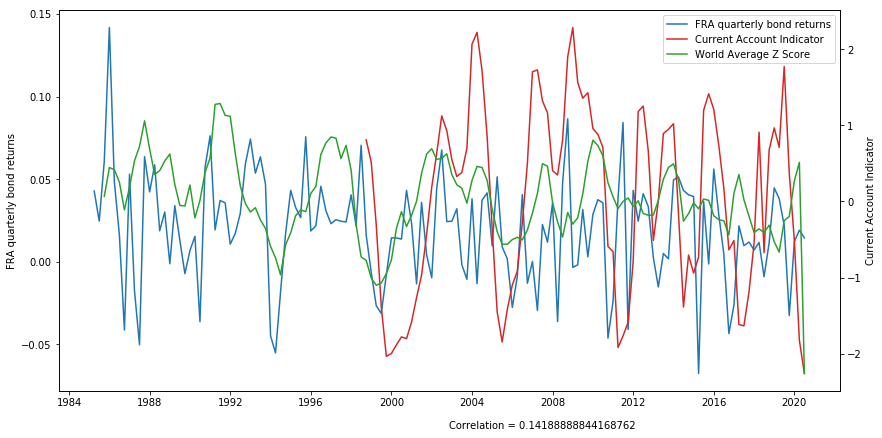

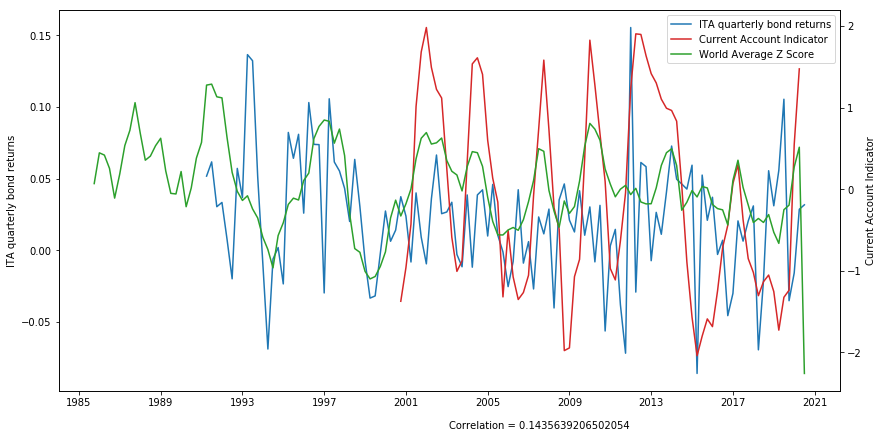

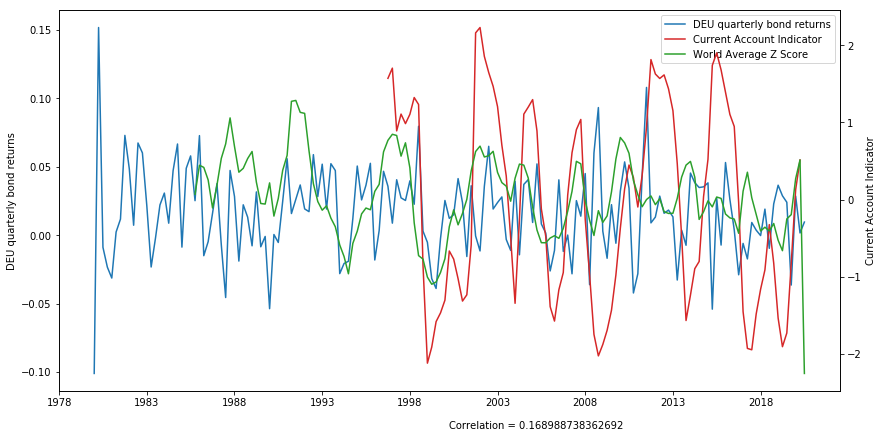

In [8]:
currentAccount_pctGDP = dl.pull("CurrAcctPctGDP")

#currentAccountChangeLastQ = currentAccount_pctGDP.shift(periods=1).rolling.apply(getChange,raw=True)

ca4YrBackend = currentAccount_pctGDP.shift(periods=1).rolling(16).mean()

ca1YrFrontend = currentAccount_pctGDP.shift(periods=1).rolling(4).mean()

##
## compute 4 year x 1 year rolling mean for current account/GDP to capture smoothed change over time.
## ca/GDP captures both potential for future interest rate increases and FX depreciations.
##

caChange = ca1YrFrontend - ca4YrBackend

caMeanChangeRolling = caChange.rolling(8).mean()
#caChangeStdevPrevious4Yrs = currentAccount_pctGDP.shift(periods=1).rolling(16).std()
caChangeStdevRolling = caChange.rolling(8).std()

#caIndicator = currentAccountChangeLast12Months / currentAccountMeanPrior4Yrs

#caRollingMeanPastYear = currentAccount_pctGDP.shift(periods=1).rolling(4).mean()

#caRollingMeanPrevious4Yrs = currentAccount_pctGDP.shift(periods=1).rolling(16).mean()
#caRollingStdevPrevious4Yrs = currentAccount_pctGDP.shift(periods=1).rolling(16).std()

#quarterZScore = (currentAccount_pctGDP.shift(periods=1) - caRollingMeanPrevious4Yrs)/caRollingStdevPrevious4Yrs

#zScores = quarterZScore.rolling(4).mean()

caZScores = (caChange - caMeanChangeRolling)/caChangeStdevRolling

worldAvgZ = caZScores.mean(axis=1)

for country in countries:
    
    fig, ax1 = plt.subplots(figsize = (14,7))
    ax2 = ax1.twinx()
    ax1_label = country + ' quarterly bond returns'
    ax2_label = 'Current Account Indicator'
    hr = ax1.plot(hedgedReturnsQuarterly[country].to_timestamp(), color = 'tab:blue', label = ax1_label)
    #ca = ax2.plot(caIndicator[country].to_timestamp(), color = 'tab:red', label = ax2_label)
    ca = ax2.plot(caZScores[country].to_timestamp(), color = 'tab:red', label = ax2_label)
    
    avgZ = ax2.plot(worldAvgZ.to_timestamp(), color = 'tab:green', label = "World Average Z Score")
    ax1.set_ylabel(ax1_label)
    ax2.set_ylabel(ax2_label)
    plots = hr + ca + avgZ
    labels = [plot.get_label() for plot in plots]
    ax1.legend(plots, labels, loc="best")

    correlation = hedgedReturnsQuarterly[country].corr(caZScores[country])
    ax1.annotate("Correlation = " + str(correlation),xy = (0.5,-0.1),xycoords="axes fraction")
    plt.show()
    

In [10]:
def getPosition(indicatorSeries, anticipatedCorrelation, countries):
    positions = indicatorSeries.copy()
    for country in countries:
        countryPosition = positions[country] 
        indices1 = countryPosition.index[countryPosition >= 2]
        indices2 = countryPosition.index[countryPosition <= -2]
        indices3 = countryPosition.index[(0 < countryPosition) & (countryPosition < 2)]
        indices4 = countryPosition.index[(0 > countryPosition) & (countryPosition > -2)]
        countryPosition[indices1] = anticipatedCorrelation
        countryPosition[indices2] = -1*anticipatedCorrelation
        countryPosition[indices3] = 0.5 * anticipatedCorrelation * countryPosition[indices3]
        countryPosition[indices4] = 0.5 * anticipatedCorrelation * countryPosition[indices4]
    return positions

In [11]:
caPositions = getPosition(caZScores, 1, countries).resample('1B').ffill()

In [12]:
#caIndicatorReturns = caPositions * hedgedReturnsQuarterly
caIndicatorReturns = caPositions * hedgedReturnsDaily

In [13]:
def getDates(series):
    dates = []
    for x in series.index.to_list():
        dates.append(x)
    return dates

In [14]:
def plotReturns(indicatorName, indicatorSeries, indicatorReturns, longOnlyReturns, countries):
    
    tradingDaysPerYear= 261
    
    cumulativeValue = np.cumsum(indicatorReturns)
    
    cumulativeHedgedPL = np.cumsum(longOnlyReturns)
    
    for country in countries:
        countryIndicatorReturns = indicatorReturns[country].copy().dropna()
        
        dates = getDates(countryIndicatorReturns)
        countryBondReturns = longOnlyReturns[country][dates]
        
        # compute risk-adjusted returns (per period)
        #riskAdjustedRet_bonds = np.mean(countryBondReturns)/np.std(countryBondReturns)
        #riskAdjustedRet_indicator = np.mean(countryIndicatorReturns)/np.std(countryIndicatorReturns)
          
        dailyRetBonds = gmean(1+countryBondReturns) - 1
        riskAdjustedRet_bonds = ((1 + dailyRetBonds)**tradingDaysPerYear - 1)/(np.std(countryBondReturns)*np.sqrt(tradingDaysPerYear))
        
        dailyRetIndicator = gmean(1 + countryIndicatorReturns) - 1
        riskAdjustedRet_indicator = ((1+dailyRetIndicator)**tradingDaysPerYear - 1)/(np.std(countryIndicatorReturns)*np.sqrt(tradingDaysPerYear))
        #riskAdjustedRet_indicator = (gmean(1 + countryIndicatorReturns) - 1)/(np.std(countryIndicatorReturns)*np.sqrt(261))
        
        returnsCorrelation = indicatorReturns[country].corr(longOnlyReturns[country])
        
        fig, ax1 = plt.subplots(figsize = (14,7))
        ax2 = ax1.twinx()
        ax1_label = country + ' Indicator Returns'
        ax2_label = "Position generated by " + indicatorName
        #cr = ax1.plot(np.cumsum(countryIndicatorReturns).to_timestamp(), color = 'tab:purple', label = "indicator sum")
        cr = ax1.plot((np.cumprod(1+countryIndicatorReturns)-1).to_timestamp(), color = 'tab:blue', label = ax1_label)

        indicatorPlot = ax2.plot(indicatorSeries[country].to_timestamp(), color = 'tab:red', label = ax2_label)
        #hr = ax1.plot(np.cumsum(countryBondReturns).to_timestamp(), color = 'tab:green', label = "Long-Only Bond Returns sum ")
        hr = ax1.plot((np.cumprod(1+countryBondReturns)-1).to_timestamp(), color = 'tab:green', label = "Long-Only Bond Returns")
        #rfr = ax1.plot(np.cumsum(threeMonthDailyEffective[country].to_timestamp()))
        
        ax1.set_ylabel(ax1_label)
        ax2.set_ylabel(ax2_label)

        plots = cr + indicatorPlot + hr
        labels = [plot.get_label() for plot in plots]
        ax1.legend(plots, labels, loc="best")
        
        ax1.annotate("Long Bonds Sharpe Ratio = " + str(riskAdjustedRet_bonds),xy = (0.4,-0.1),xycoords="axes fraction")
        ax1.annotate("Indicator Sharpe Ratio = " + str(riskAdjustedRet_indicator),xy = (0.4,-0.2),xycoords="axes fraction")
        ax1.annotate("Correlation btwn long-only and indicator returns: " + str(returnsCorrelation),xy = (0.4,-0.3),xycoords="axes fraction")
        
        plt.show()

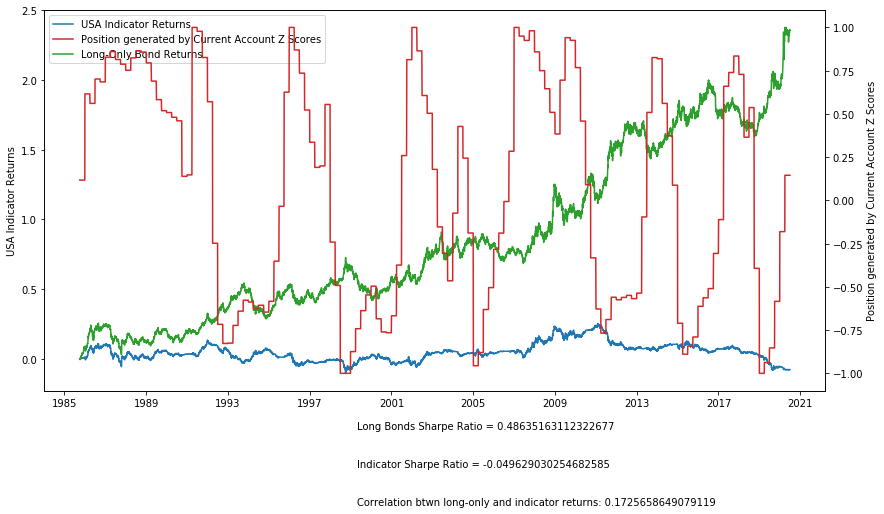

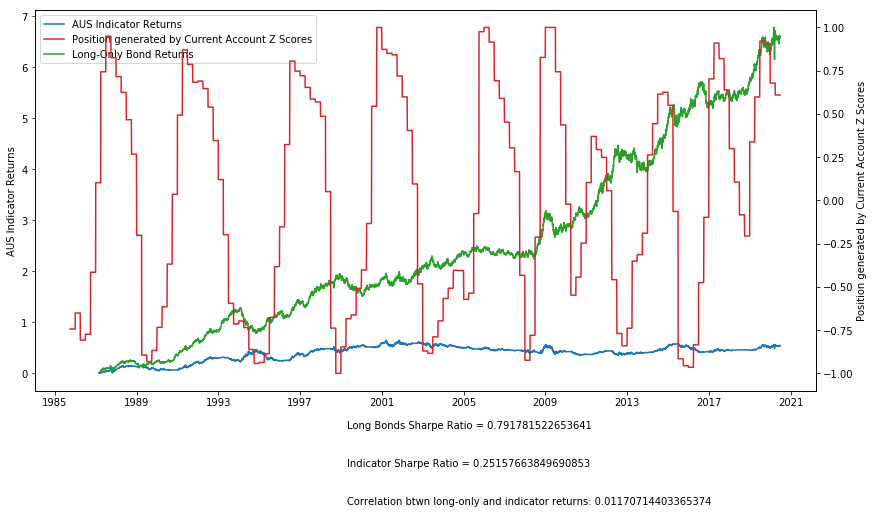

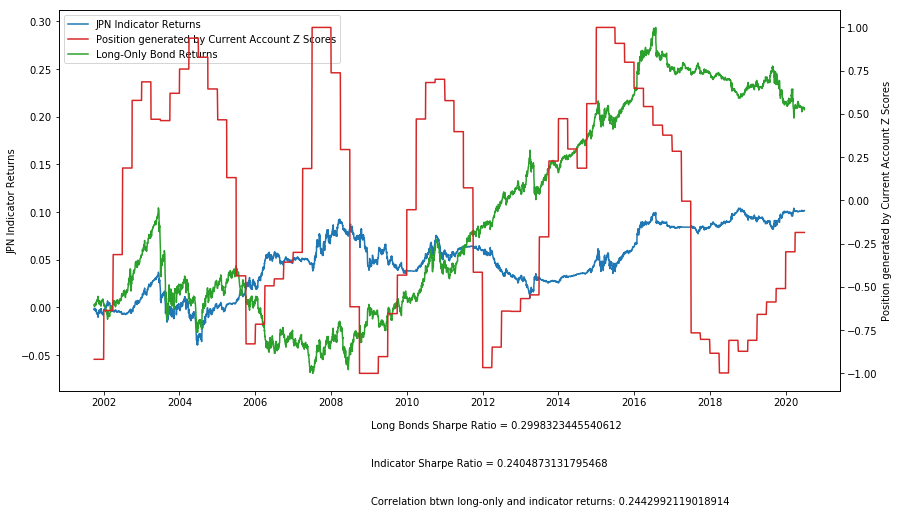

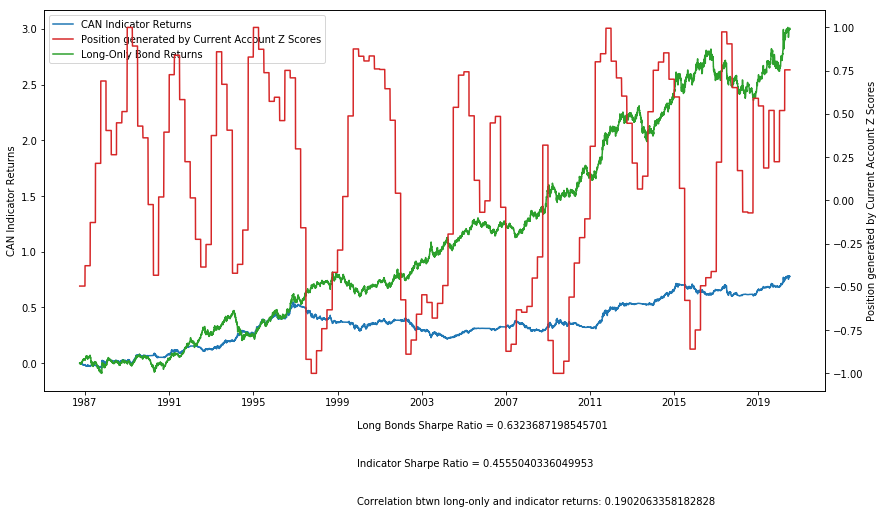

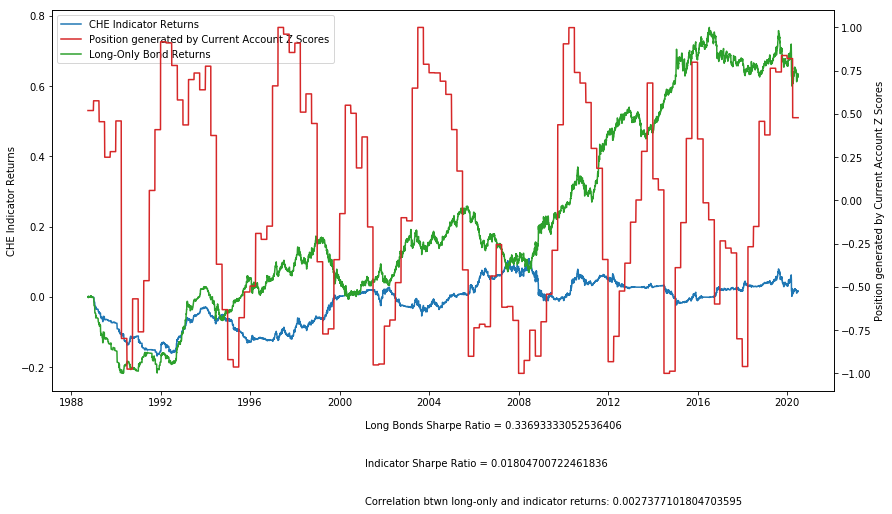

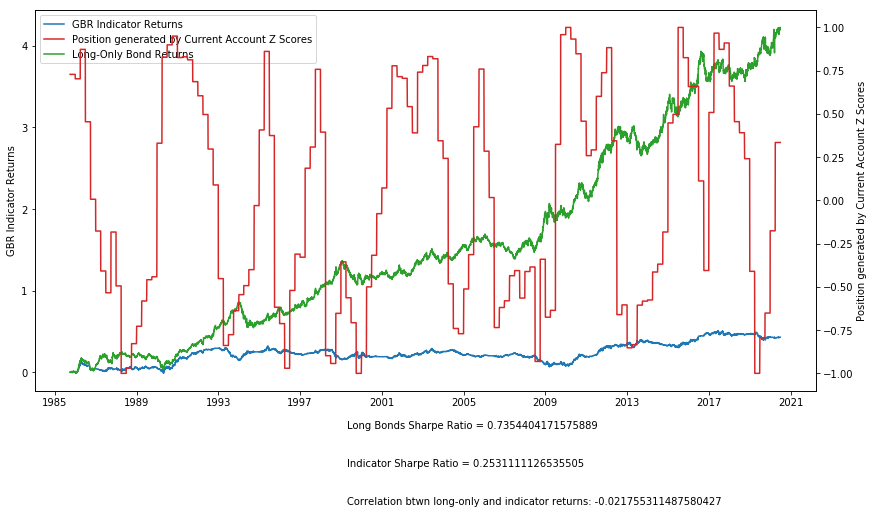

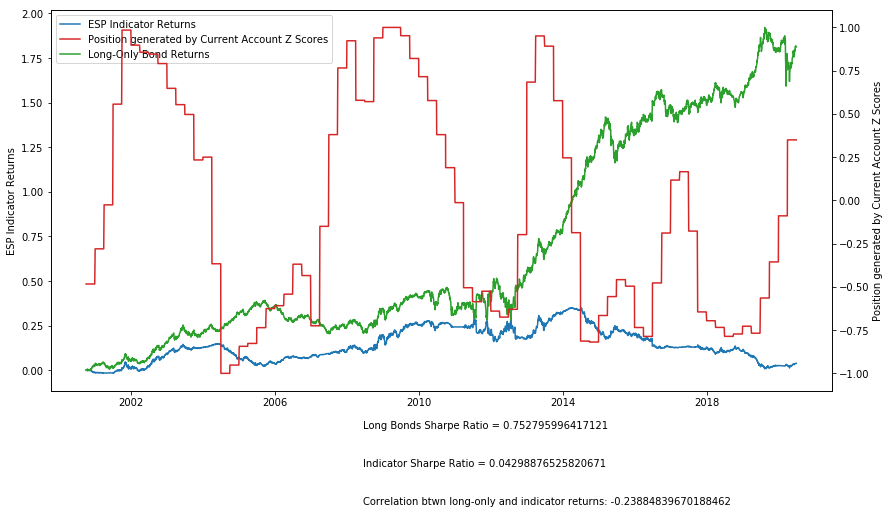

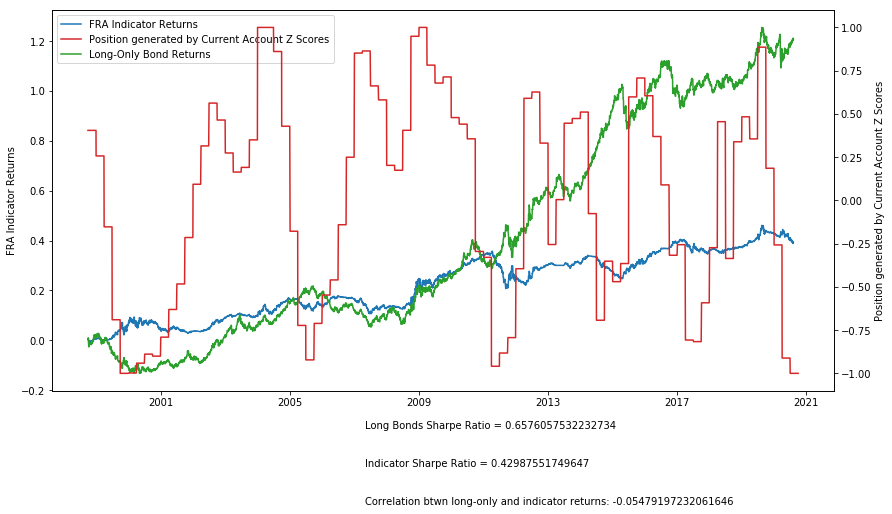

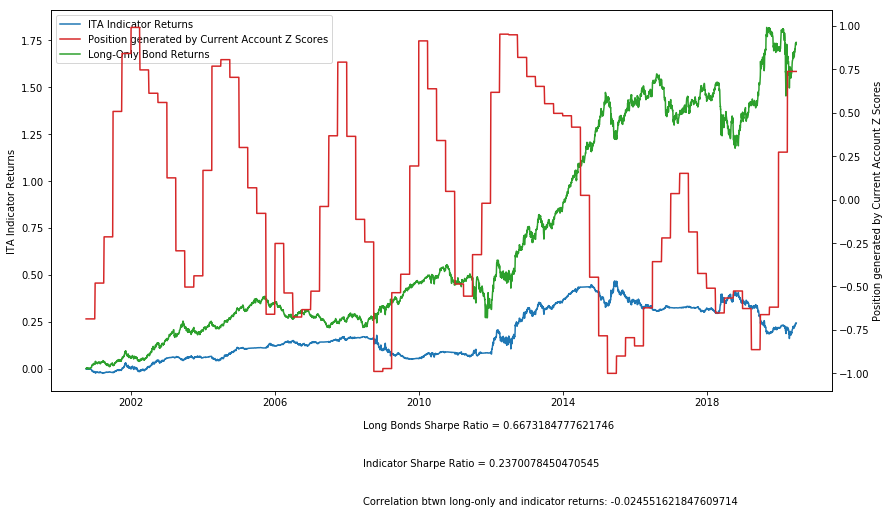

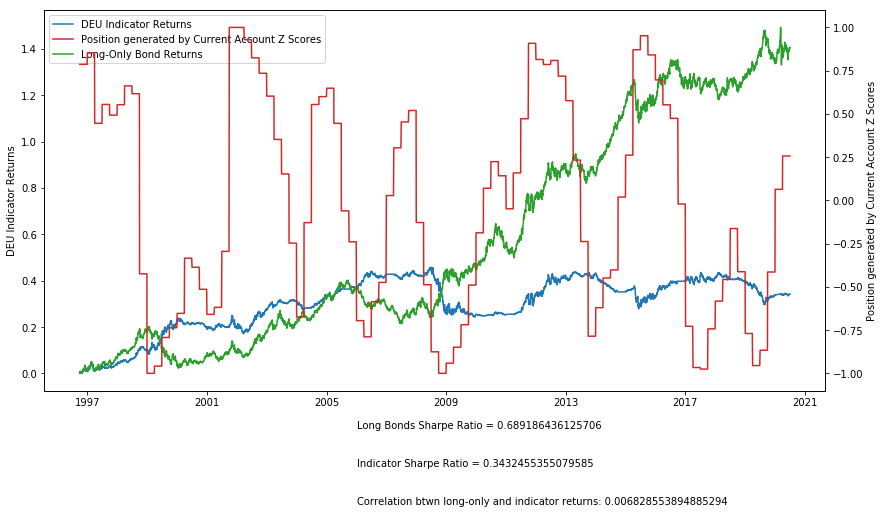

In [15]:
plotReturns("Current Account Z Scores", caPositions, caIndicatorReturns, hedgedReturnsDaily, countries)



## Bond Premium

### Bond premium gives a view into general risk sentiment. Bond premium is also faster moving than current account. I computed the 6x18 rolling mean. This moving average change allows us to smoothe changes out over time. The bond premium indicator generates positive returns for almost every country, and the returns generated by the indicator are largely uncorrelated (correlation coefficient < 0.2) with the returns of the long-only strategy.

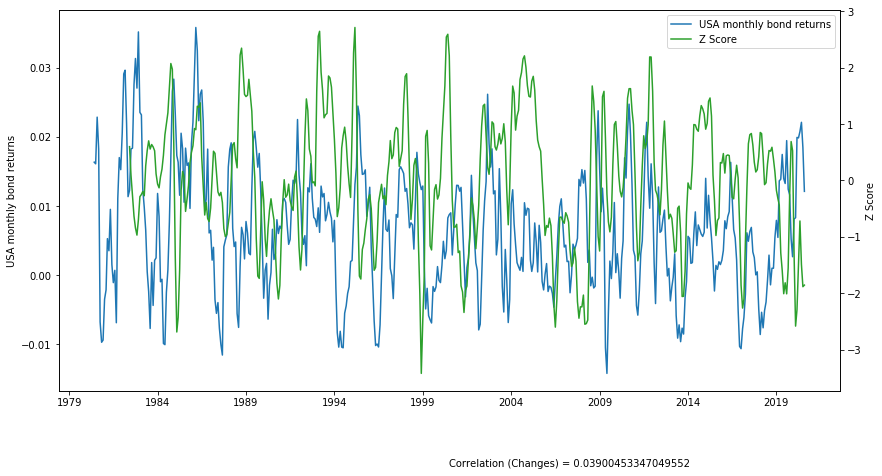

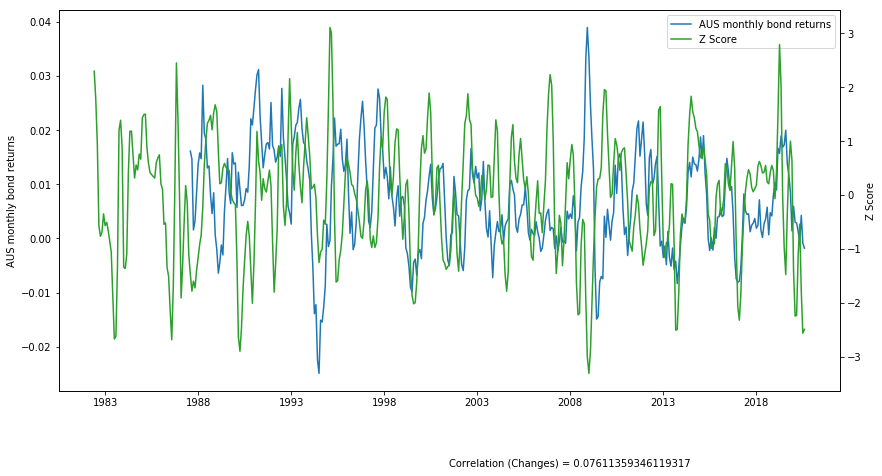

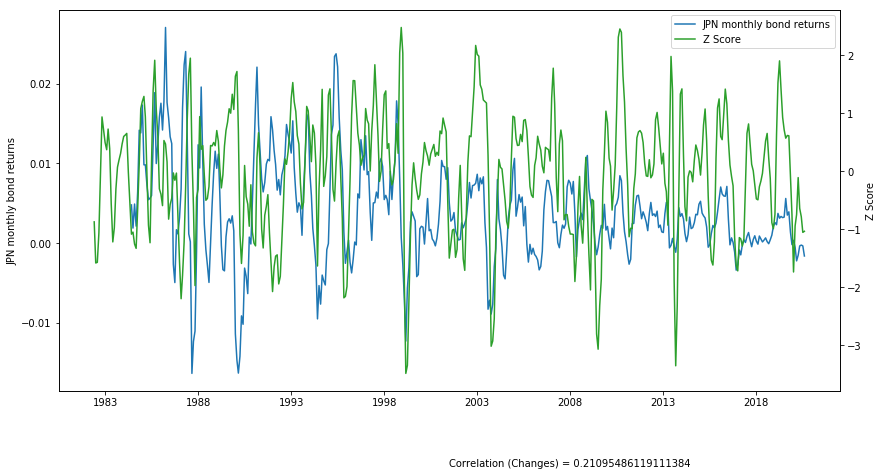

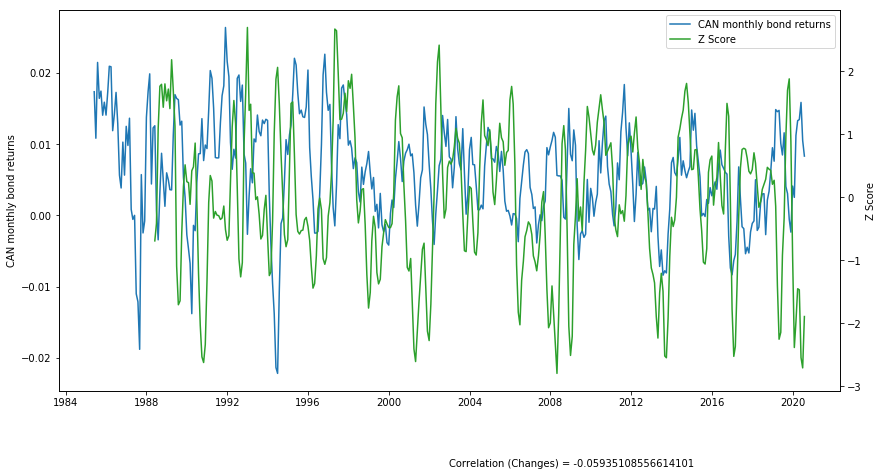

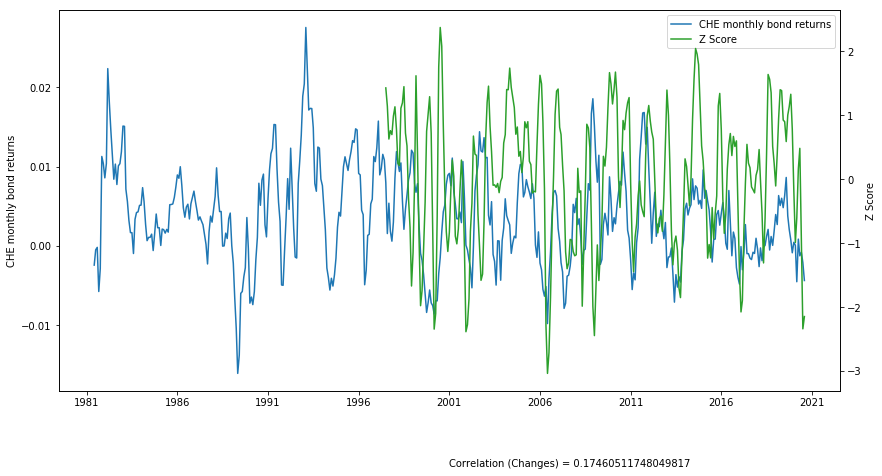

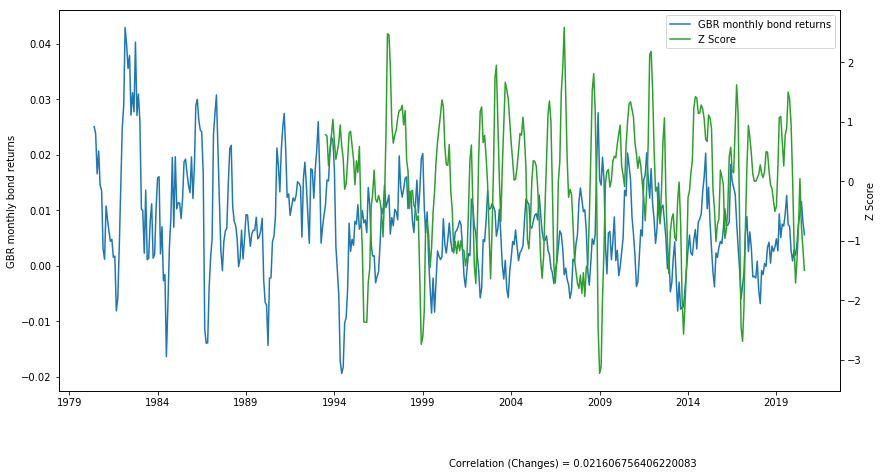

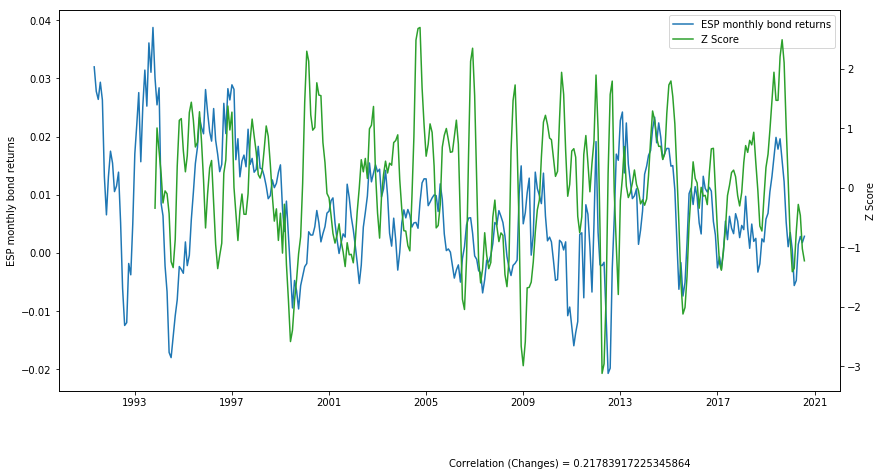

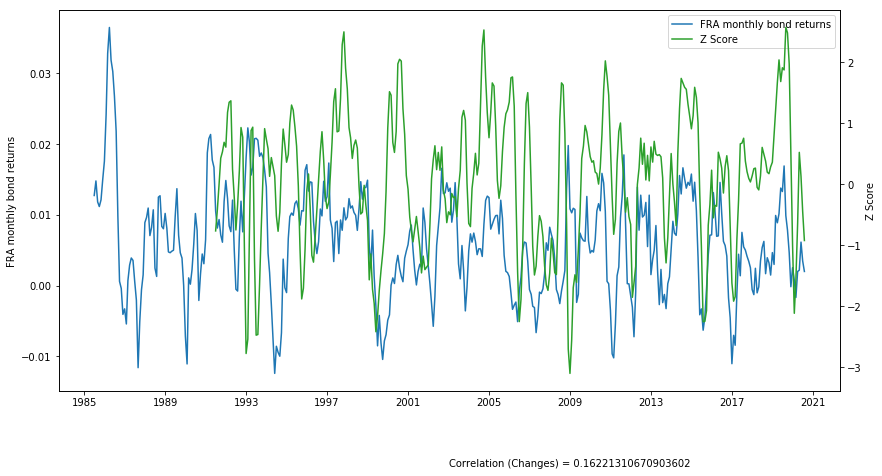

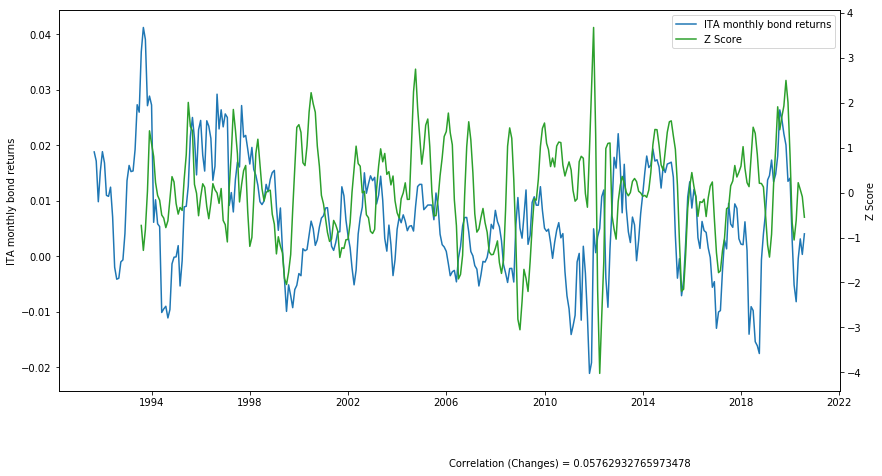

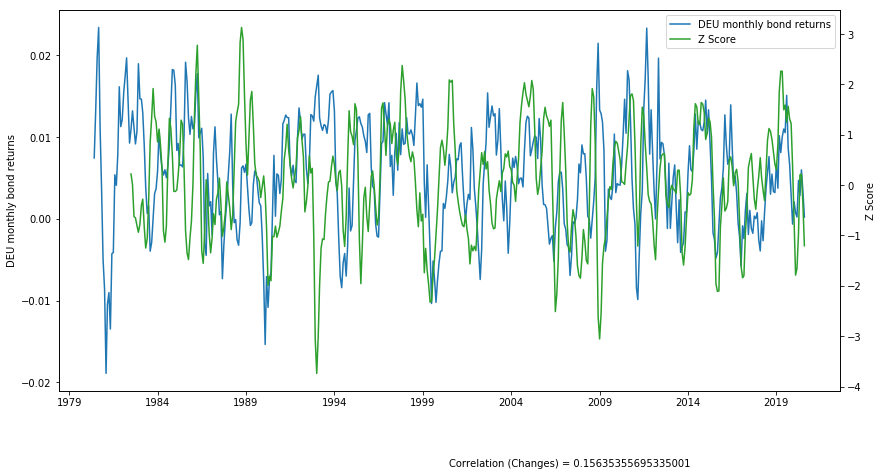

In [16]:
longRates = dl.pull('LongRates')
shortRates = dl.pull('ShortRates')

bondPremium = longRates - shortRates
#curveHeight = (longRates + shortRates)/2


#bp_over_ch = bondPremium.shift(periods=1)/curveHeight.shift(periods=1)

#bp_over_ch = bp_over_ch.rolling(6).mean()

#bp_ = bondPremium.shift(periods=1).rolling(6).mean().diff()

##
## Compute 6x18 rolling mean for bond premium
##

bpBackend = bondPremium.shift(periods=1).rolling(6).mean()

#bpRollingMean = bondPremium.shift(periods=1).rolling(24).mean()

#bpRollingStdev = bondPremium.shift(periods=1).rolling(24).std()

bpFrontend = bondPremium.shift(periods=1).rolling(3).mean()

bpChange = bpFrontend - bpBackend

bpChangeRollingMean = bpChange.rolling(24).mean()

bpChangeRollingStdev = bpChange.rolling(24).std()

## compute z score

bpZScore = (bpChangeRollingMean - bpChange)/bpChangeRollingStdev

#bpLevelZ = (bpRollingMean - bpFrontend)/bpRollingStdev

hedgedReturnsMonthly = bondReturnIndex.resample('1M').apply(period_return).rolling(6).mean()

for country in countries:
    
    fig, ax1 = plt.subplots(figsize = (14,7))
    ax2 = ax1.twinx()
    ax1_label = country + ' monthly bond returns'
    ax2_label = 'Z Score'
    
    hr = ax1.plot(hedgedReturnsMonthly[country].to_timestamp(), color = 'tab:blue', label = ax1_label)
    
    bp = ax2.plot(bpZScore[country].to_timestamp(), color = 'tab:green', label = ax2_label)
    ax1.set_ylabel(ax1_label)
    ax2.set_ylabel(ax2_label)
    plots = hr + bp
    labels = [plot.get_label() for plot in plots]
    ax1.legend(plots, labels, loc="best")
    correlation = hedgedReturnsMonthly[country].corr(bpZScore[country])
    #ax1.annotate("Correlation (Levels) = " + str(correlation1),xy = (0.5,-0.1),xycoords="axes fraction")
    ax1.annotate("Correlation (Changes) = " + str(correlation),xy = (0.5,-0.2),xycoords="axes fraction")
    plt.show()

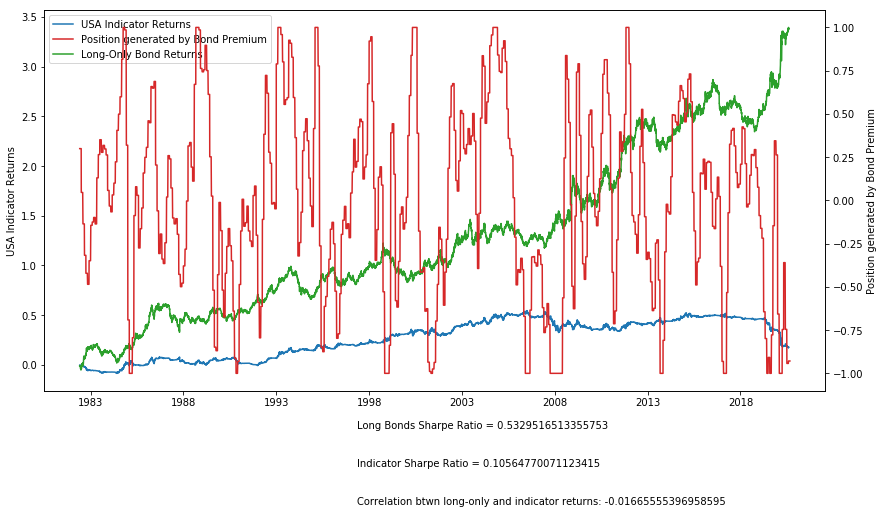

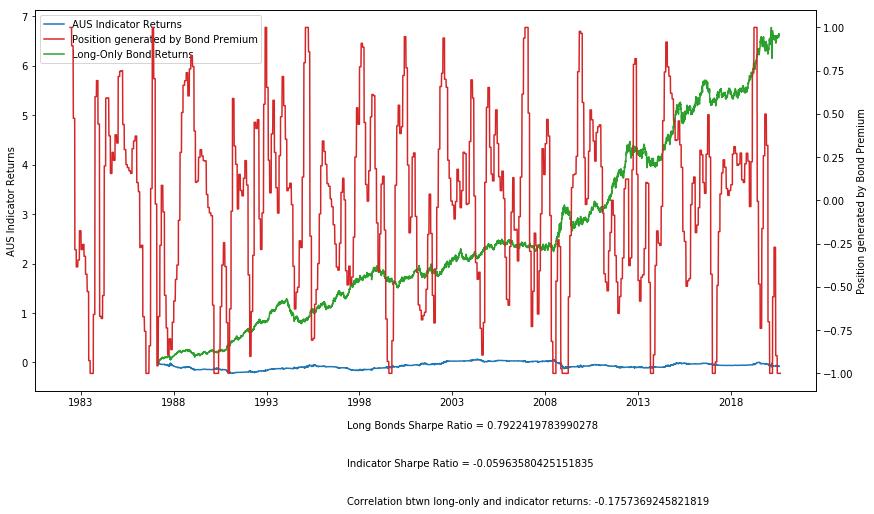

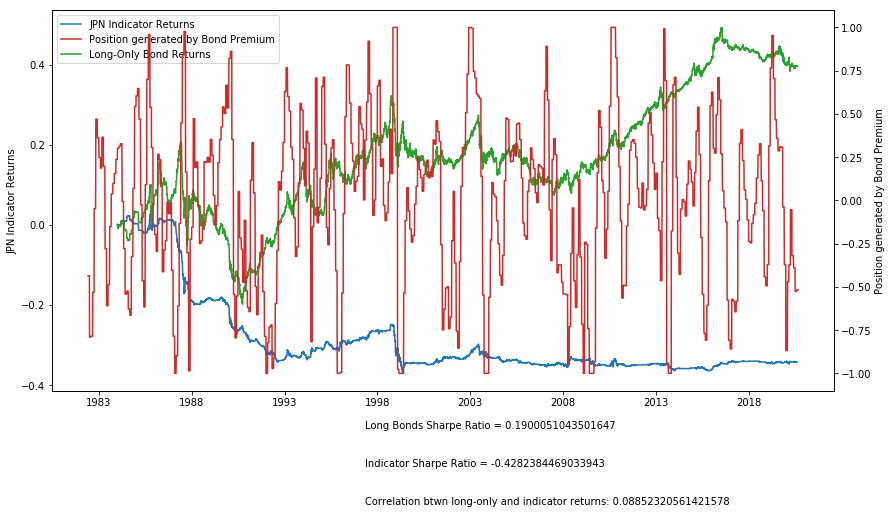

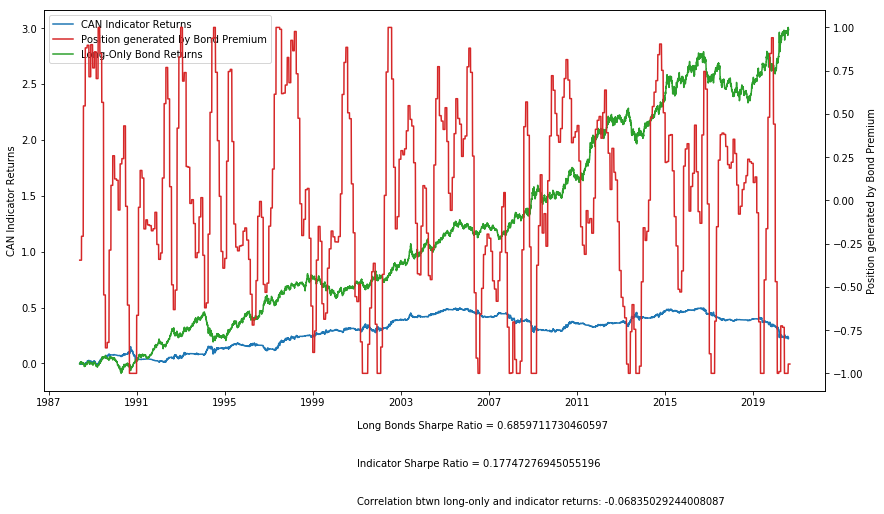

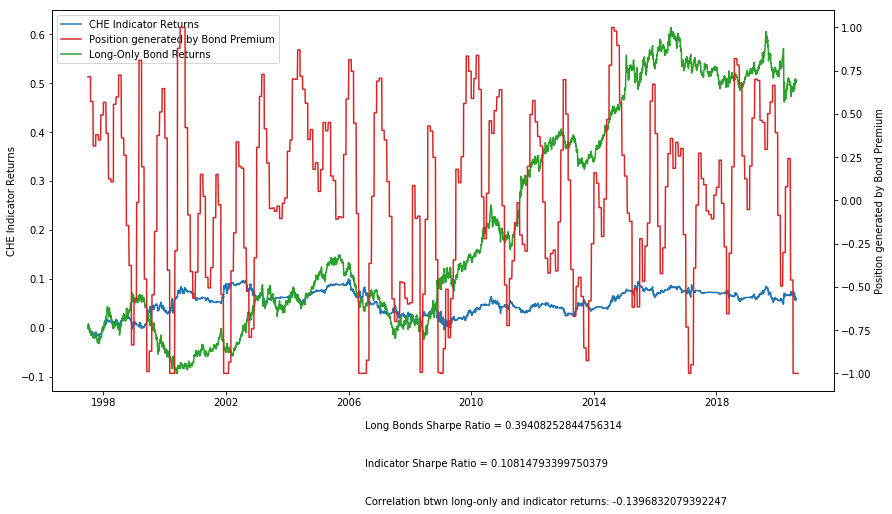

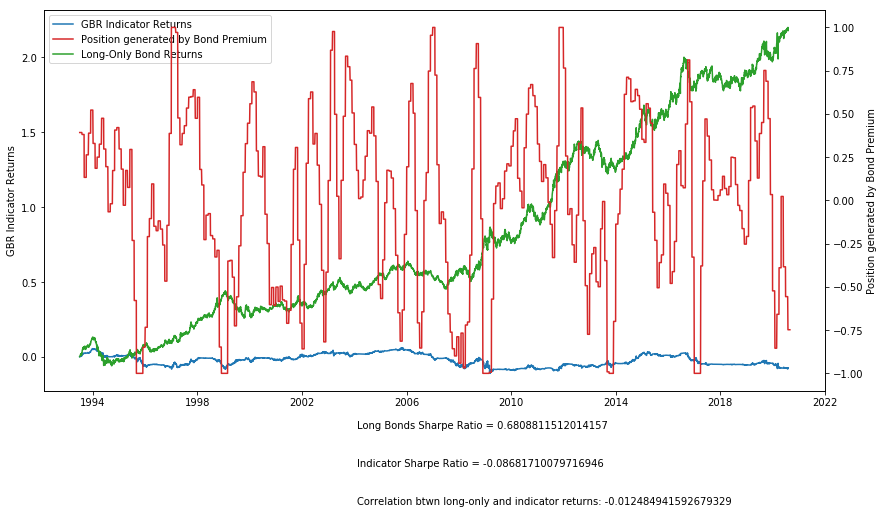

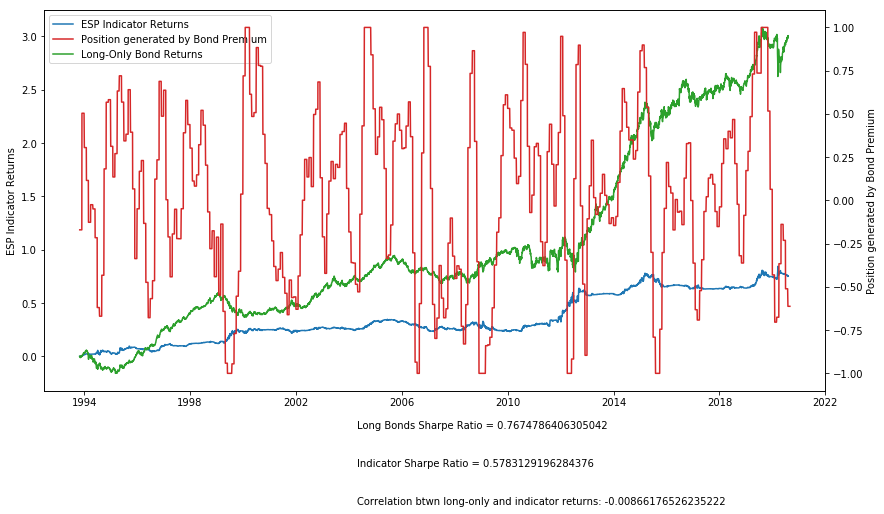

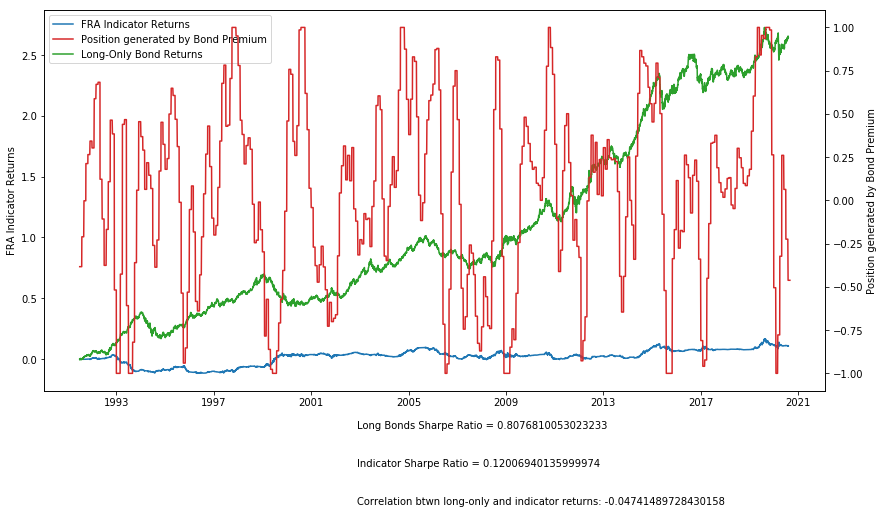

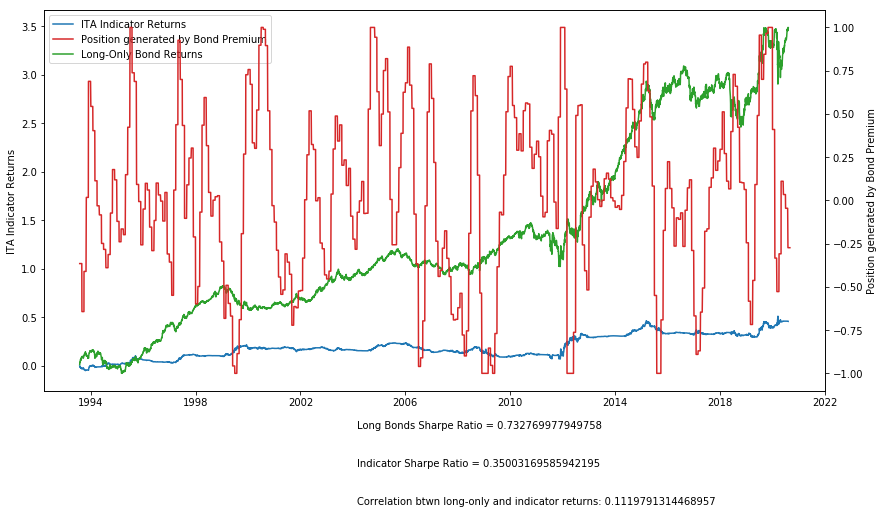

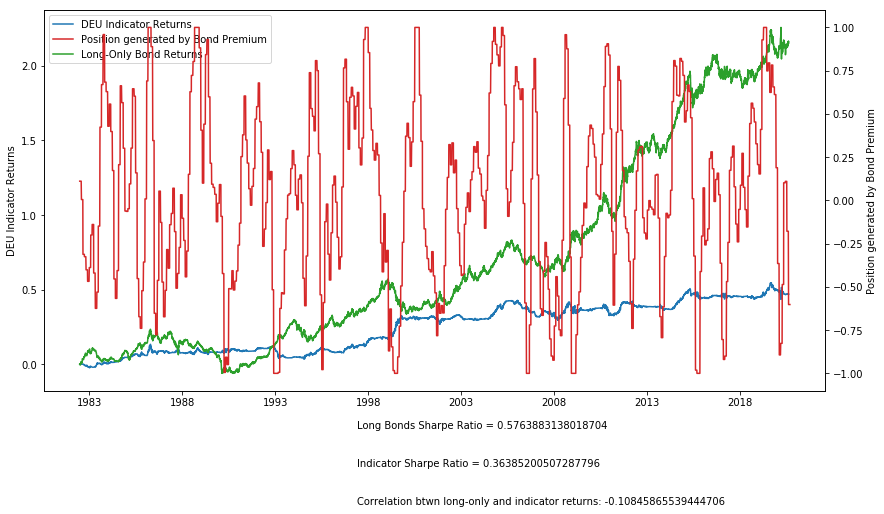

In [17]:
bpPositions = getPosition(bpZScore, 1, countries).resample('1B').ffill()

bpIndicatorReturns = bpPositions * hedgedReturnsDaily

plotReturns("Bond Premium", bpPositions, bpIndicatorReturns, hedgedReturnsDaily, countries)


# FX Appreciation

### I used changes in the BIS Real Broad Effective Exchange Rate Index as a proxy for appreciation/depreciation of currency (the fxTrdWts data set included in the data library only had data for 5 of the 10 countries). I computed a 1x12 month rolling mean to capture changes in FX. FX appreciation/depreciation gives a forward-looking view into inflation expectations (through the lever of the increasing/decreasing foreign demand for a countries goods that occurs when a countries currency depreciates/appreciates). The indicator doesn't work perfectly for all countries (most notably the US, Japan, Switzerland, and Italy), but for the rest of the countries it performs moderately. I plan on refining this indicator further and hopefully improving the performance. It is worth noting, though, that in the countries where the indicator delivers positive returns, the returns of the indicator are largely uncorrelated with the returns of the long-only bond strategy.

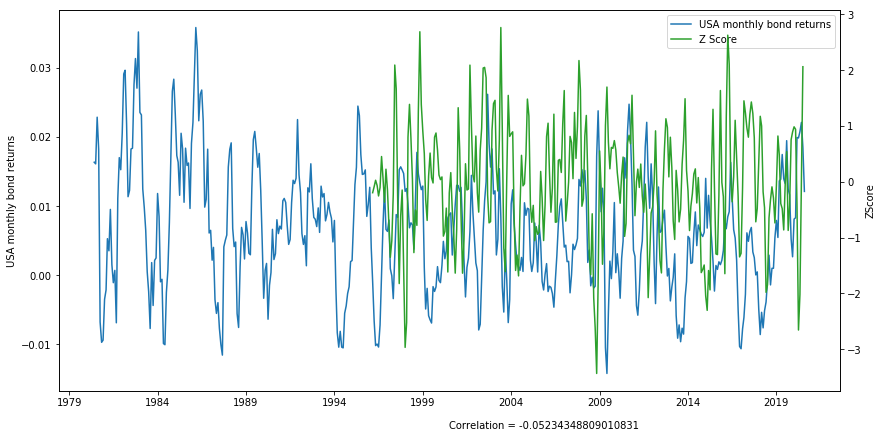

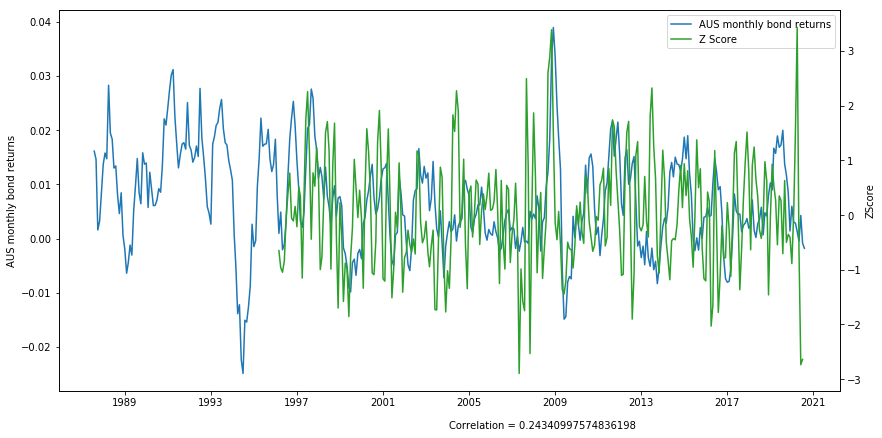

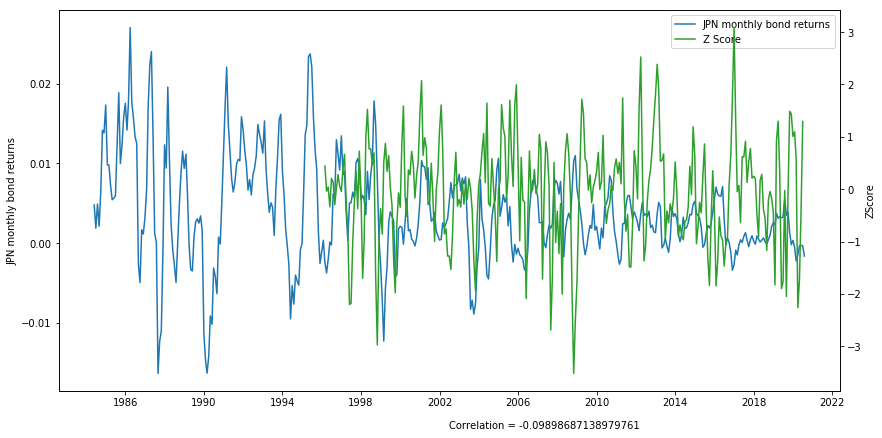

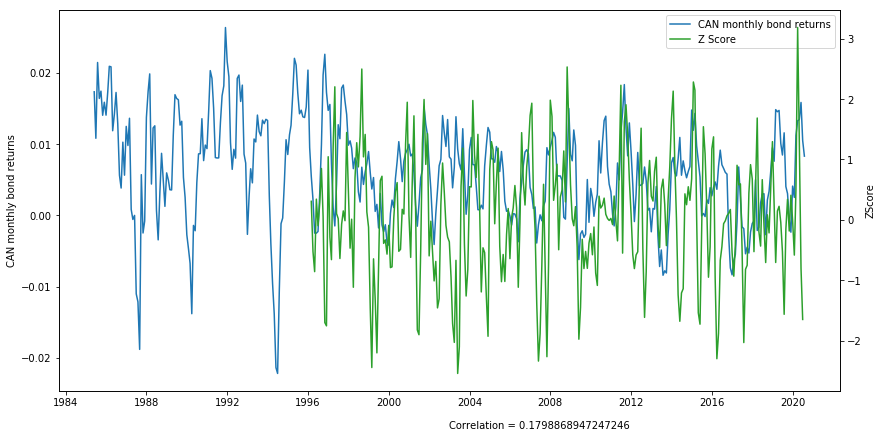

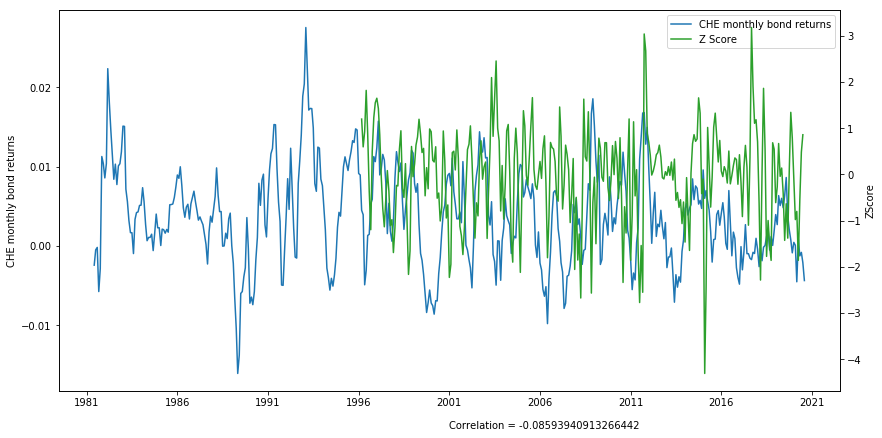

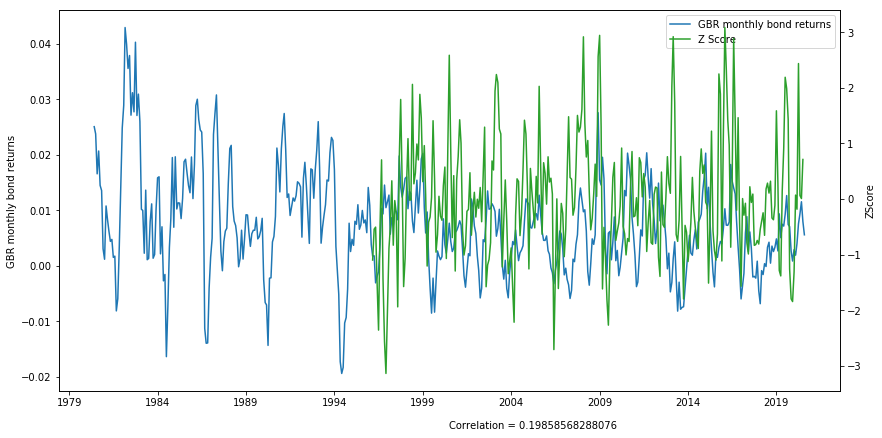

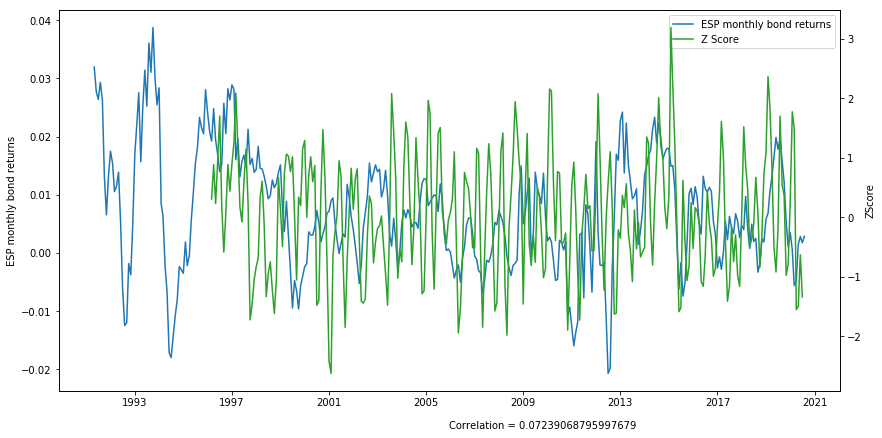

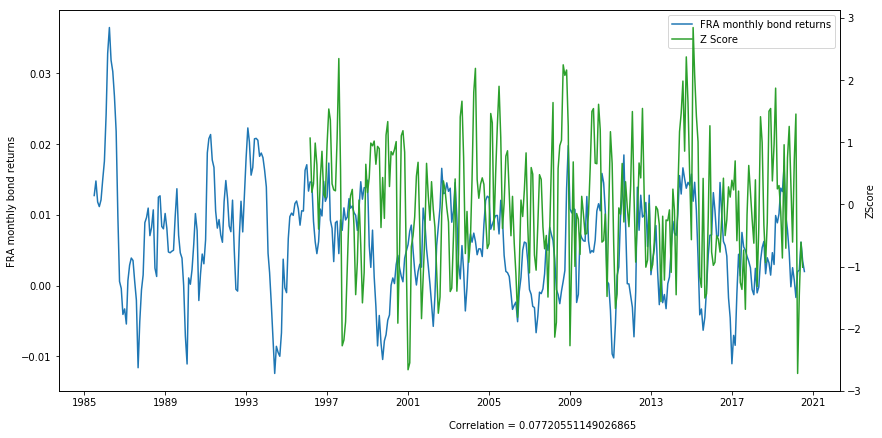

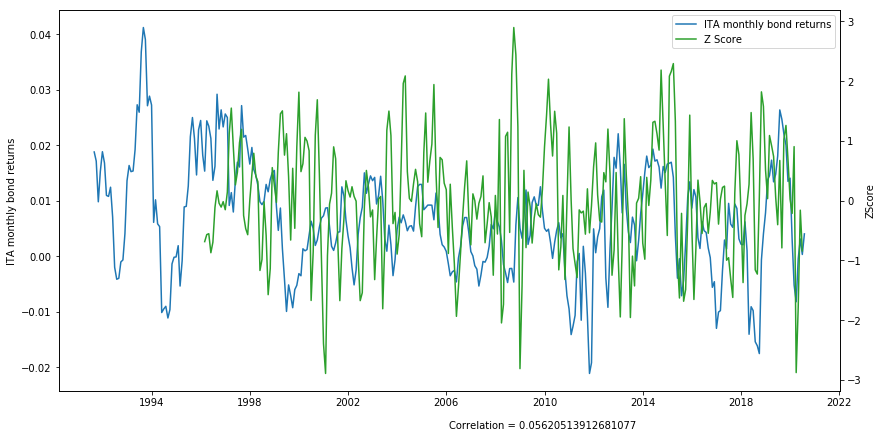

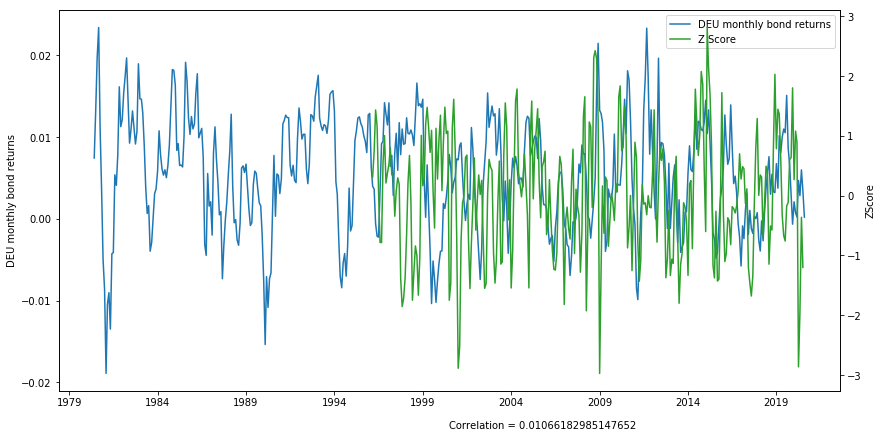

In [18]:
fx = dl.pull("bisRealBroadEffExchRateIndex")

fxBackend = fx.shift(periods=1).rolling(3).mean()

fxFrontend = fx.shift(periods=1).rolling(1).mean()

fxChange = fxFrontend - fxBackend

fxChangeRollingMean = fxChange.rolling(24).mean()

fxChangeRollingStdev = fxChange.rolling(24).std()

fxZScore = (fxChangeRollingMean - fxChange)/fxChangeRollingStdev

for country in countries:
    
    fig, ax1 = plt.subplots(figsize = (14,7))
    ax2 = ax1.twinx()
    ax1_label = country + ' monthly bond returns'
    ax2_label = 'ZScore'
    hr = ax1.plot(hedgedReturnsMonthly[country].to_timestamp(), color = 'tab:blue', label = ax1_label)
    
    fx = ax2.plot(fxZScore[country].to_timestamp(), color = 'tab:green', label = "Z Score")
    ax1.set_ylabel(ax1_label)
    ax2.set_ylabel(ax2_label)
    plots = hr + fx
    labels = [plot.get_label() for plot in plots]
    ax1.legend(plots, labels, loc="best")
    correlation = hedgedReturnsMonthly[country].corr(fxZScore[country])
    ax1.annotate("Correlation = " + str(correlation),xy = (0.5,-0.1),xycoords="axes fraction")
    plt.show()


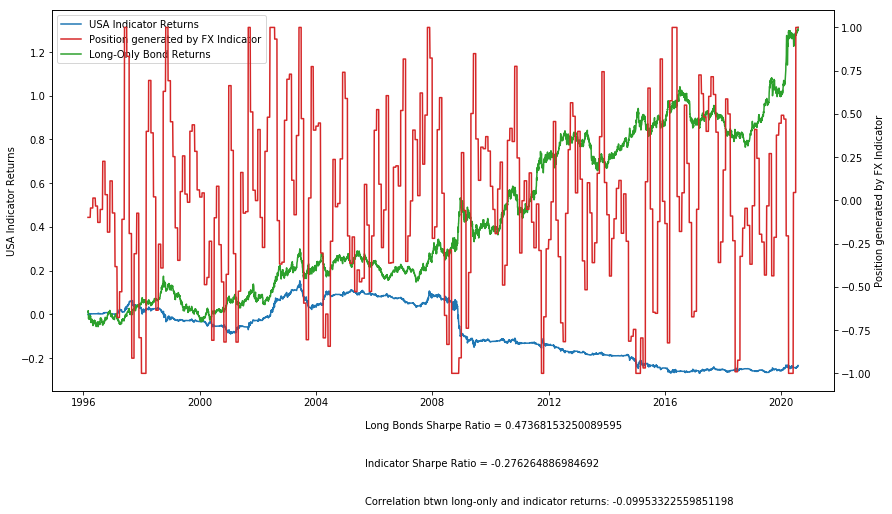

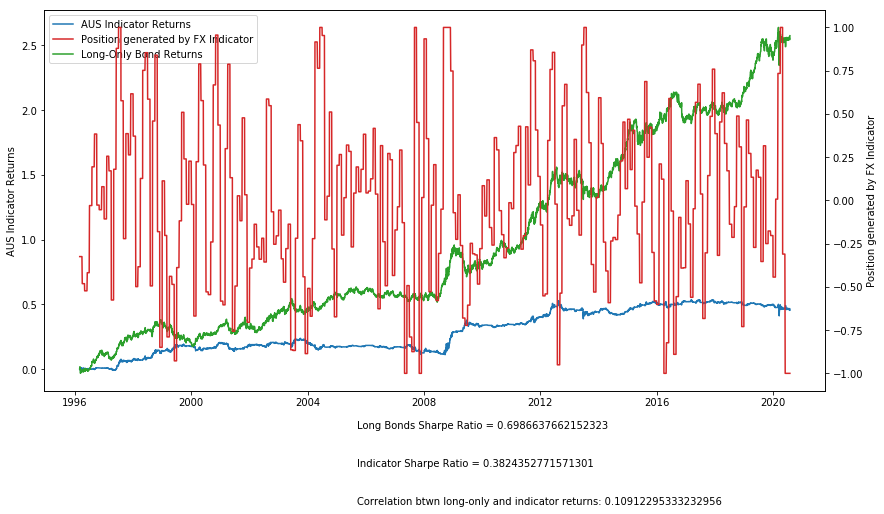

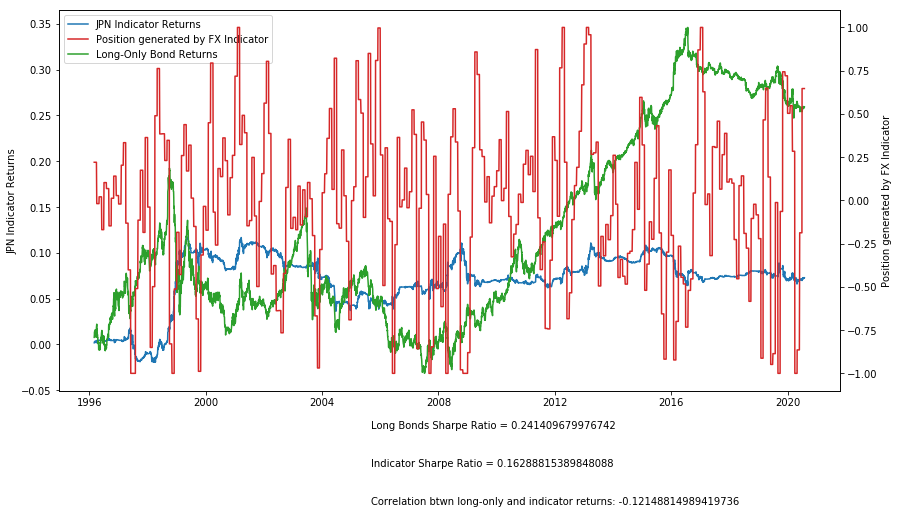

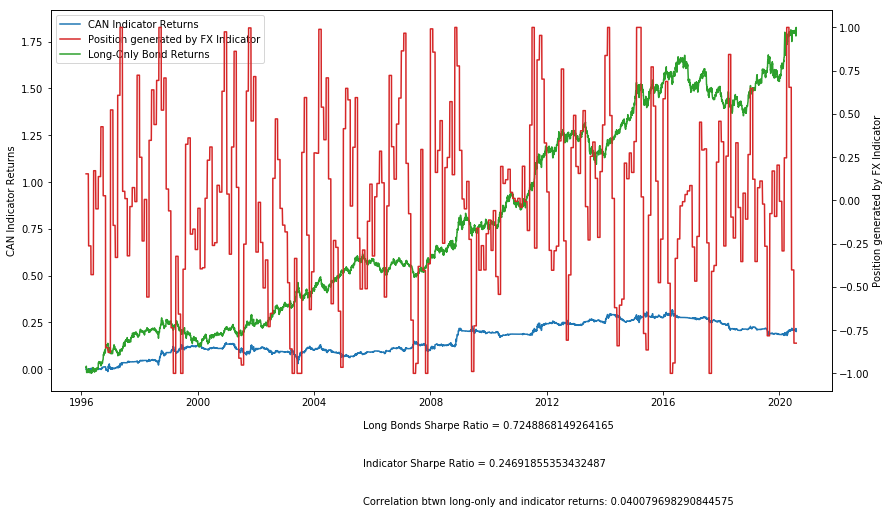

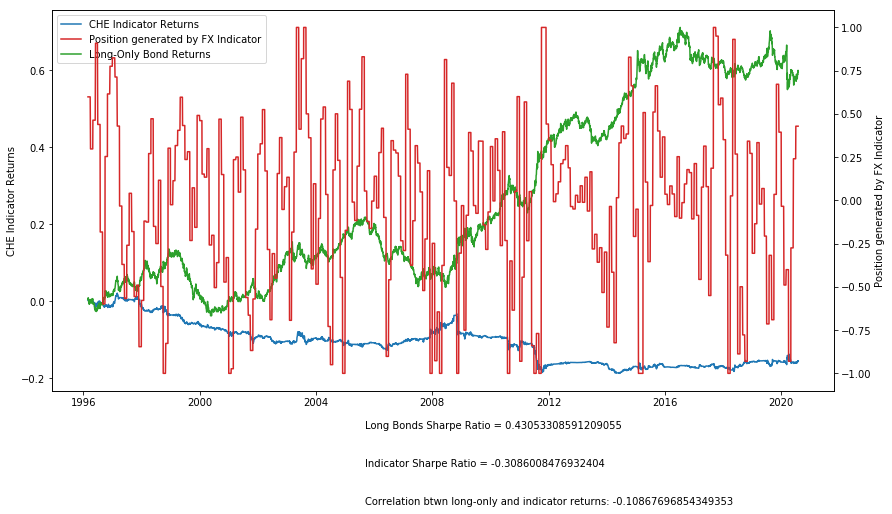

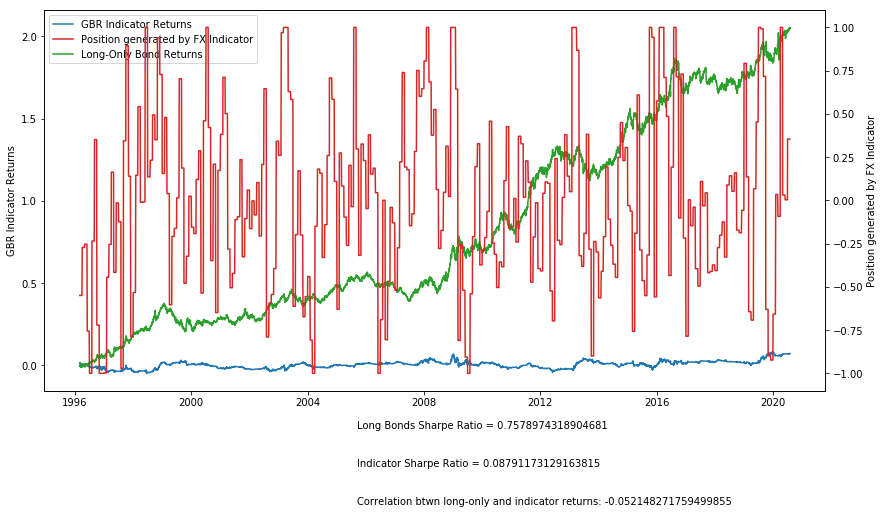

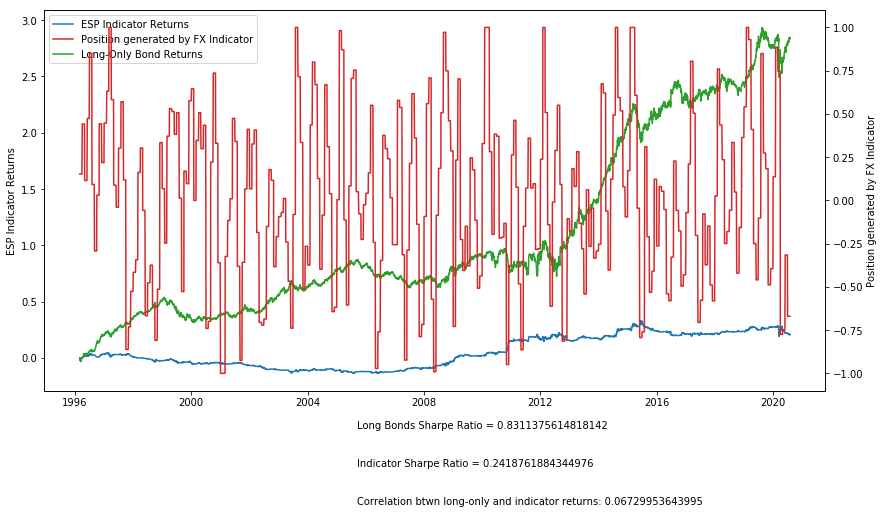

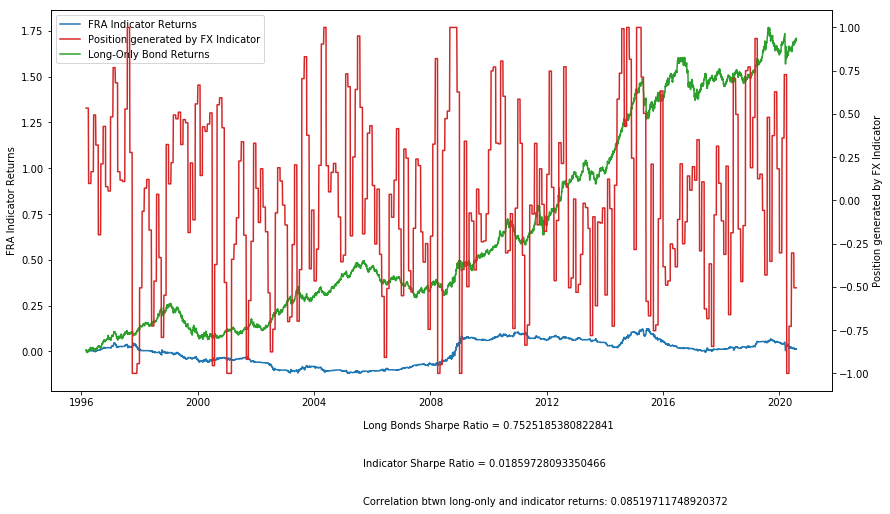

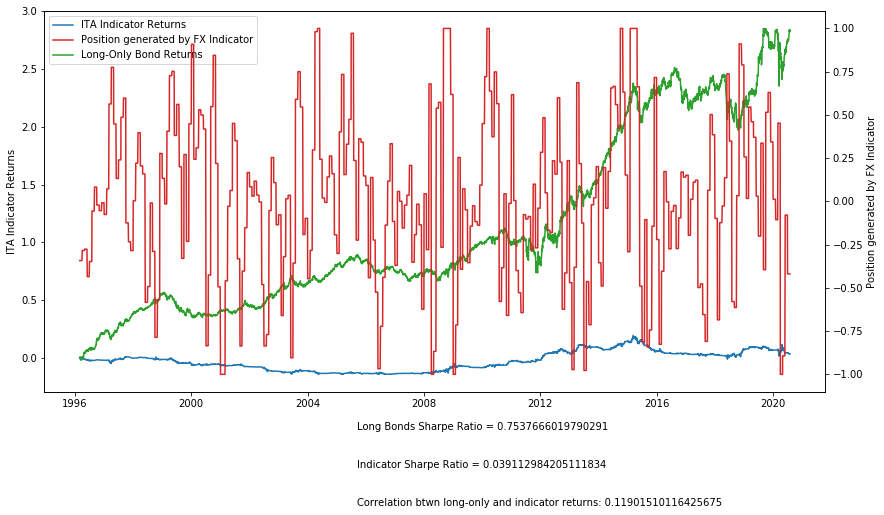

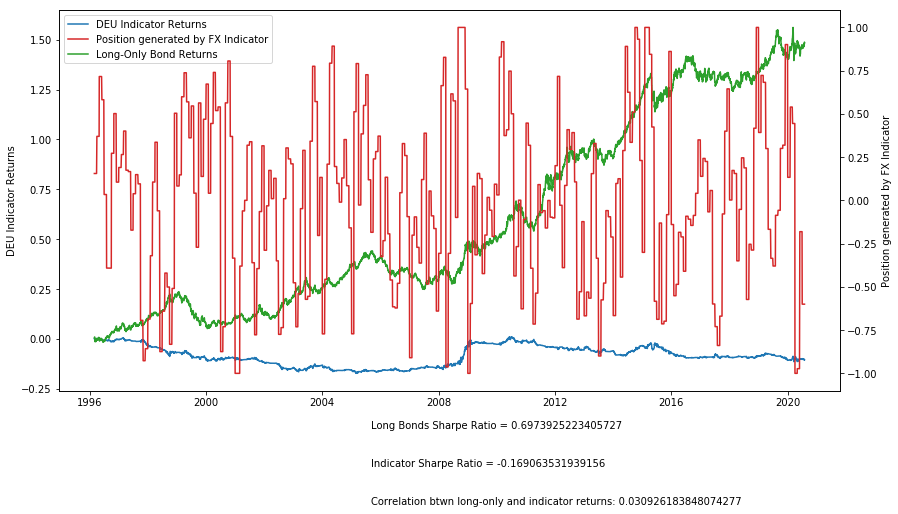

In [19]:
fxPositions = getPosition(fxZScore, 1, countries).resample('1B').ffill()

fxIndicatorReturns = fxPositions * hedgedReturnsDaily

plotReturns("FX Indicator", fxPositions, fxIndicatorReturns, hedgedReturnsDaily, countries)


# Combining Indicators

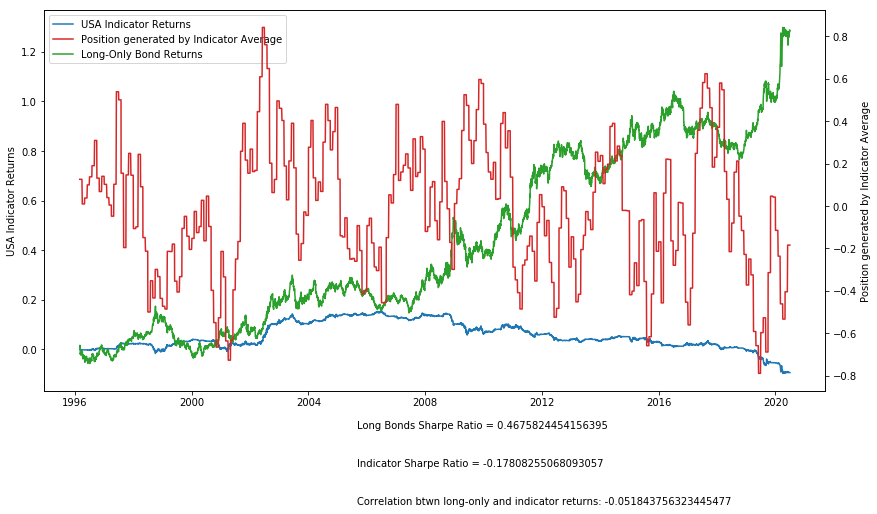

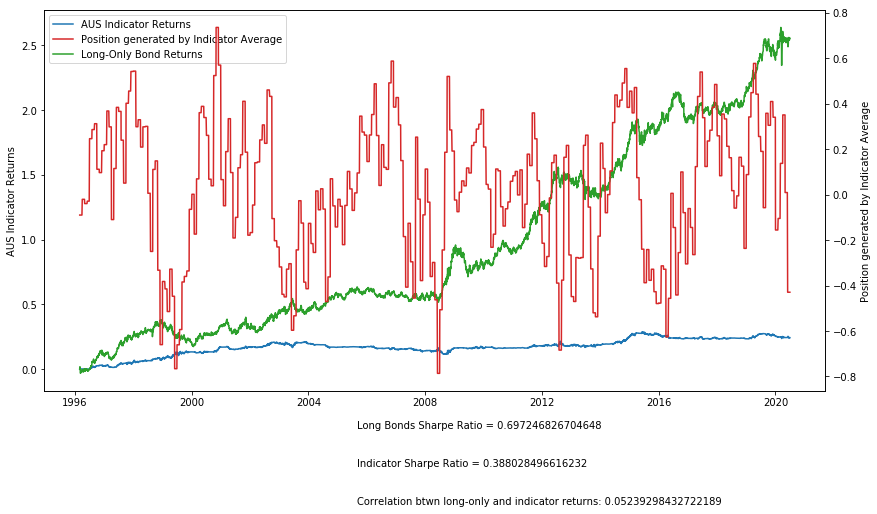

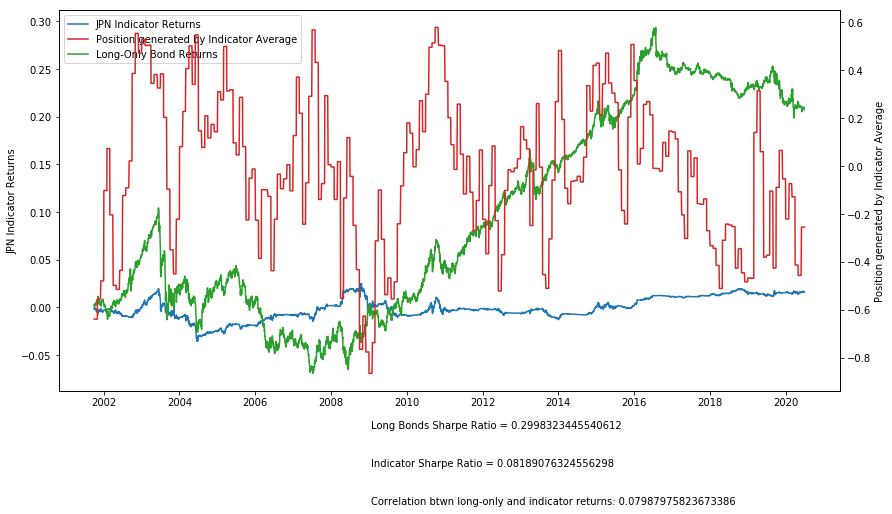

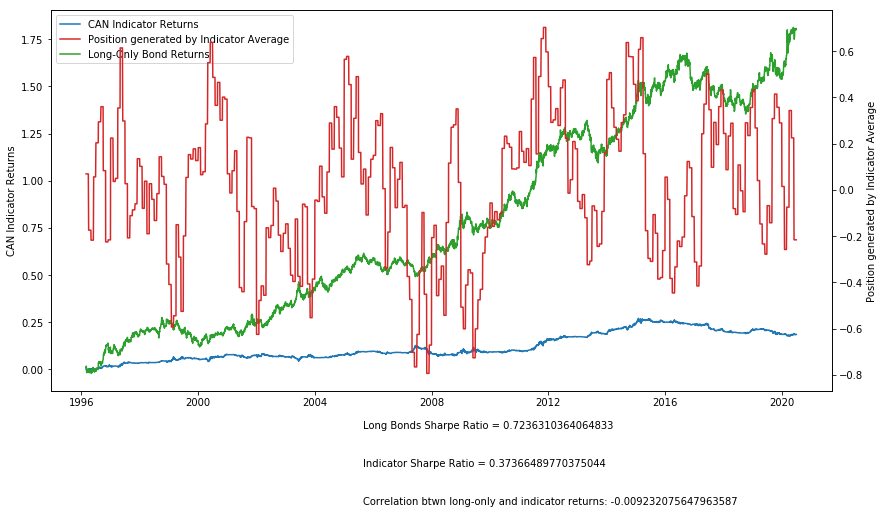

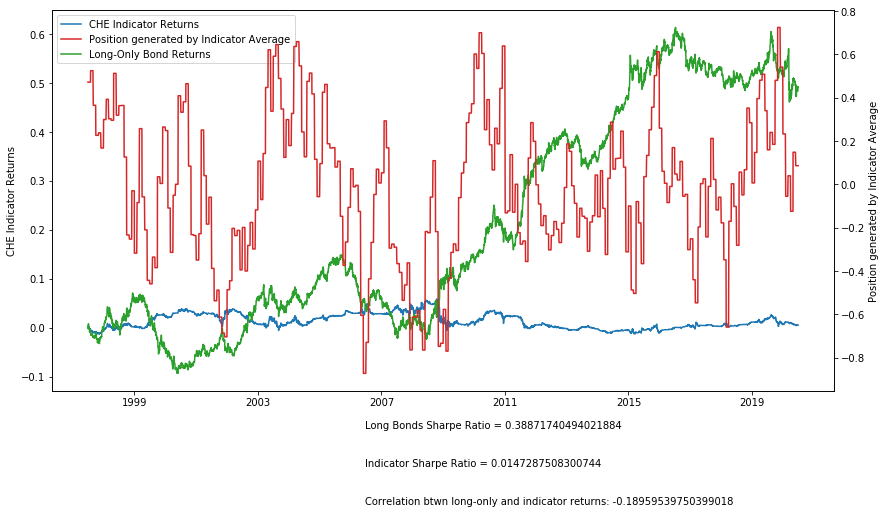

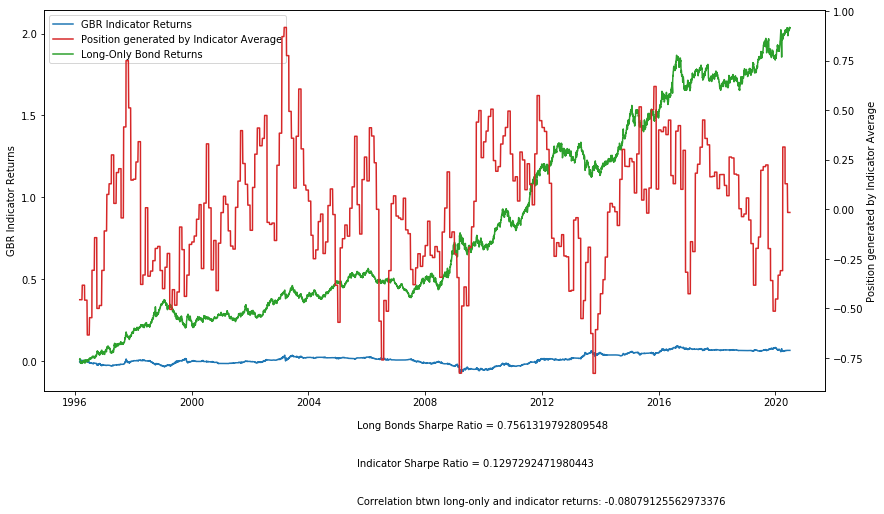

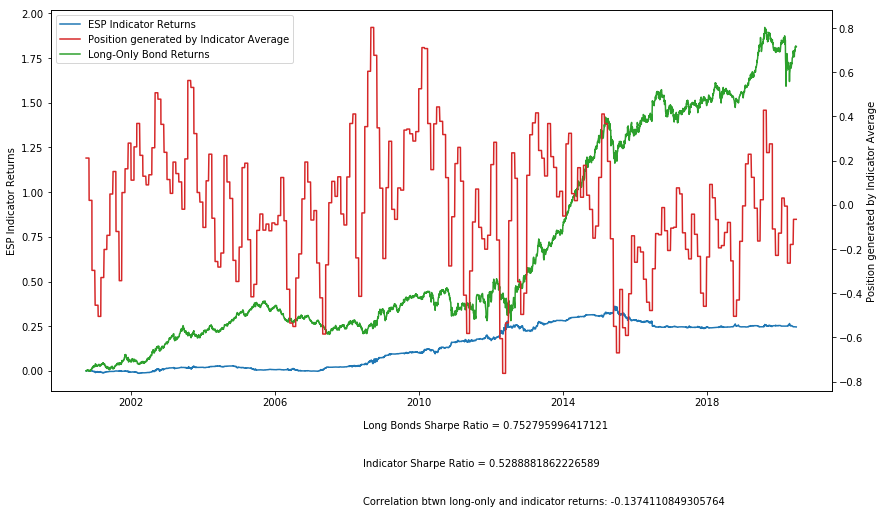

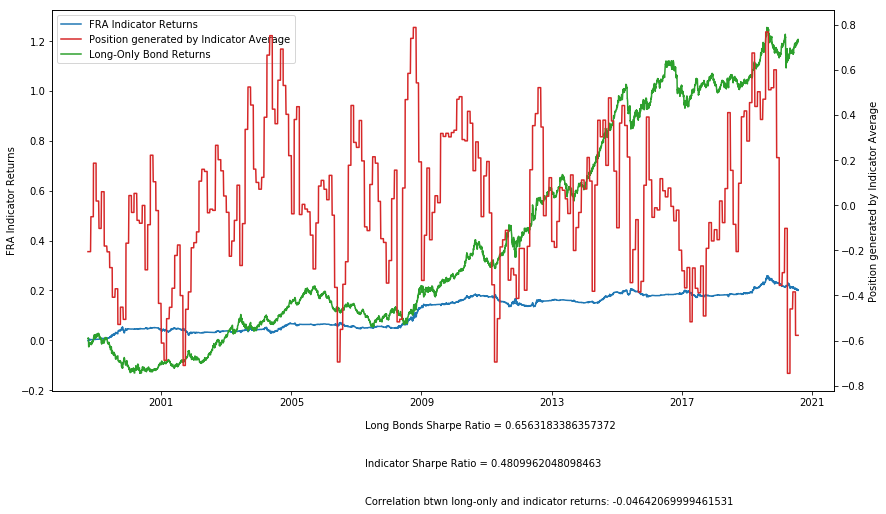

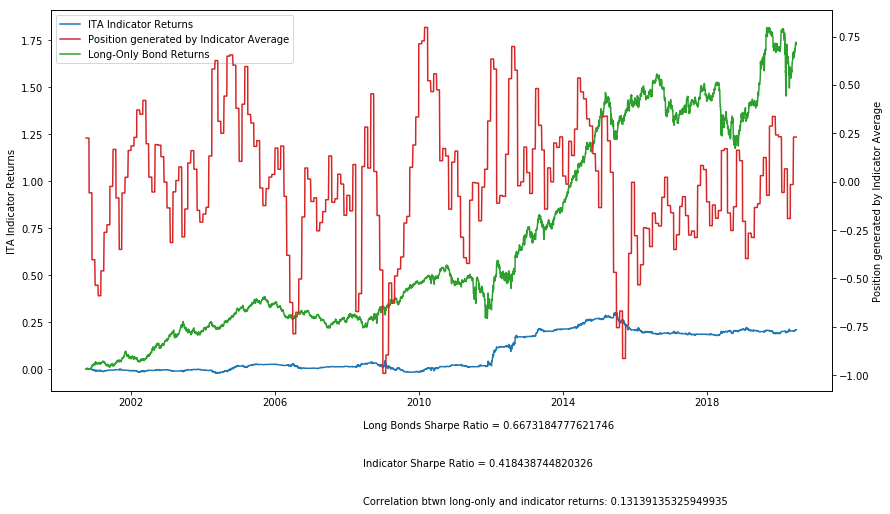

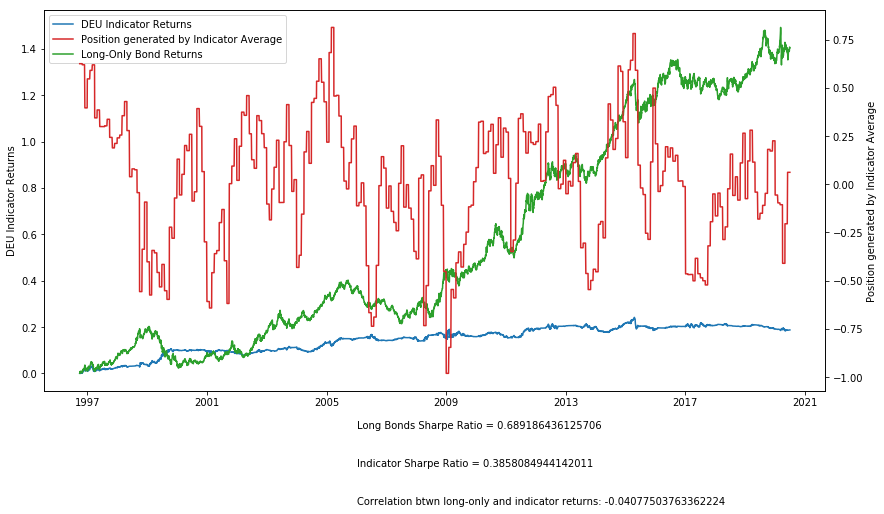

In [20]:
caWeight = 1/3
bpWeight = 1/3
fxWeight = 1/3

combinedPositions = caWeight * caPositions + bpWeight * bpPositions + fxWeight * fxPositions
combinedReturns = combinedPositions * hedgedReturnsDaily

plotReturns("Indicator Average", combinedPositions, combinedReturns, hedgedReturnsDaily, countries)

In [21]:

for country in countries:
    ca = caPositions[country]
    bp = bpPositions[country]
    fx = fxPositions[country]
    
    print(country + " correlation(ca, bp): " + str(ca.corr(bp)))
    print(country + " correlation(ca, fx): " + str(ca.corr(fx)))
    print(country + " correlation(bp, fx): " + str(bp.corr(fx)))
    print()
    

USA correlation(ca, bp): -0.12171422080279375
USA correlation(ca, fx): 0.11860814002512052
USA correlation(bp, fx): -0.16470007289751273

AUS correlation(ca, bp): -0.06499791095434404
AUS correlation(ca, fx): 0.06533394114251978
AUS correlation(bp, fx): -0.010536985023622393

JPN correlation(ca, bp): 0.08611186896918555
JPN correlation(ca, fx): -0.1367180428049016
JPN correlation(bp, fx): -0.026775784217354534

CAN correlation(ca, bp): -0.04124591118101667
CAN correlation(ca, fx): 0.10610333543769176
CAN correlation(bp, fx): -0.0970529455869963

CHE correlation(ca, bp): 0.28934168567222046
CHE correlation(ca, fx): -0.08046197674798139
CHE correlation(bp, fx): 0.010894920518082484

GBR correlation(ca, bp): 0.10934798114921407
GBR correlation(ca, fx): -0.0516105422109109
GBR correlation(bp, fx): -0.12329647293504918

ESP correlation(ca, bp): -0.2970260340864993
ESP correlation(ca, fx): -0.08599849430624205
ESP correlation(bp, fx): 0.0996656714834608

FRA correlation(ca, bp): -0.121434961

# Sandbox

In [22]:
#import numpy as np
#from sklearn.metrics import r2_score
#for country in countries:
    
    #if len(caIndicator[country].dropna()) <= len(hedgedReturns[country].dropna()):
        #naIndices = zScores[country].index[zScores[country].isna()]
    #else:
        #naIndices = hedgedReturns[country].index[hedgedReturns[country].isna()]
    #zs_country = caIndicator[country].drop(naIndices)
    #hr_country = hedgedReturns[country].drop(naIndices)
    
    #otherNa = zs_country.index[zs_country.isna()]
    #otherNa = caIndicator.index[zs_country.isna()]

    #zs_country = zs_country.drop(otherNa)
    #hr_country = hr_country.drop(otherNa)
    
    #m, b = np.polyfit(zs_country, hr_country, 1)
    #plt.scatter(zScores[country],hedgedReturns[country])
    #plt.title("Z Scores vs. hedged returns: " + country)
    #plt.plot(zs_country, m*zs_country + b)
    
    #r2 = r2_score(hr_country, m*zs_country + b)
    #plt.annotate("R^2 = " + str(r2),xy = (0.5,-0.2),xycoords="axes fraction")
    
    #X = zs_country
    #y = hr_country

    #X2 = sm.add_constant(X)
    #est = sm.OLS(y, X2)
    #est2 = est.fit()
    #print(est2.summary())
    
    #plt.show()
    